# Book 9: Feature Selection Pipeline
 
## Hybrid Two-Phase Approach
 
| Phase | Method | Features | Purpose |
|-------|--------|----------|---------|
| **Phase 1** | Cluster-Based Reduction | 166 -> 142 | Remove redundant/correlated features |
| **Phase 2** | Iterative SHAP Winnowing | 142 -> 26 | Fine-tune with up to 10 removals per iteration |
| **Phase 3** | CV Stability Analysis | Validate stability | Confirm selection is robust across CV folds |
 
## Key Features
- **Dynamic clustering threshold** via silhouette score (not fixed 0.7)
- **2:1 SHAP weighting** for positive cases (model handles imbalance via scale_pos_weight)
- **Clinical must-keep features** - preserve interpretable CRC signals regardless of ranking
- **3-fold CV stability analysis** - identify features robust across different train/val splits
- **Test set tracked but not used for decisions** - test metrics logged at every iteration for post-hoc sweet spot analysis
- **Granular checkpoints** - stop anytime and resume without starting over
- **Automatic stop conditions** - stops when hitting minimum feature threshold or no features meet removal criteria
 
## Checkpoint System
Checkpoints saved after each step using portable formats (JSON for models, Parquet for DataFrames).
Kill notebook anytime, re-run to resume. Backward compatible with legacy pickle checkpoints.

## Configuration

In [0]:
# ============================================================================
# CONFIGURATION - Modify these as needed
# ============================================================================

# Resume behavior: Set to True to check for and resume from checkpoints
# Set to False to start fresh (will prompt to confirm clearing checkpoints)
AUTO_RESUME = True

# =============================================================================
# PHASE 2 REMOVAL CRITERIA (from original CRC_ITER1_MODEL-PREVALENCE.py)
# =============================================================================
# Feature must meet AT LEAST 2 of 3 criteria to be eligible for removal:
#   1. Near-zero SHAP importance (< ZERO_SHAP_THRESHOLD)
#   2. Negative-biased ratio (< NEG_BIAS_RATIO_THRESHOLD)
#   3. Bottom percentile by SHAP (< BOTTOM_PERCENTILE)
# =============================================================================
ZERO_SHAP_THRESHOLD = 0.0005     # Near-zero importance threshold (raised from 0.0002)
NEG_BIAS_RATIO_THRESHOLD = 0.25  # Negative-bias ratio threshold (raised from 0.15)
BOTTOM_PERCENTILE = 12           # Bottom percentile threshold (raised from 8)

# Iteration limits - gradual reduction to prevent model destabilization
MAX_REMOVALS_EARLY = 10          # Cap for iterations 1-5 (was 30, caused crashes)
MAX_REMOVALS_LATE = 5            # Cap for iterations 6+ (finer control)
LATE_PHASE_ITERATION = 5         # Switch to finer control after this iteration
MIN_FEATURES_THRESHOLD = 25      # Target final feature count

# Phase 1 validation gate
PHASE1_MAX_VAL_DROP = 0.10       # Allow up to 10% drop in Phase 1

# Visualization thresholds (reference lines in plots, not used for stopping)
MAX_VAL_AUPRC_DROP = 0.05        # 5% drop reference line
MAX_GAP_INCREASE = 0.02          # Gap increase reference line

# Clustering configuration
# Use silhouette optimization, but constrain to reasonable range
# Target: ~40-60 clusters for ~170 features (allows meaningful cluster reduction)
MIN_CLUSTERING_THRESHOLD = 0.60  # Floor - prevents too many tiny clusters
MAX_CLUSTERING_THRESHOLD = 0.85  # Ceiling - prevents too few giant clusters
TARGET_CLUSTER_RANGE = (40, 70)  # Prefer thresholds giving this many clusters

# Threshold search range
THRESHOLD_MIN = 0.50
THRESHOLD_MAX = 0.90
THRESHOLD_STEP = 0.05

# Random seed for reproducibility
RANDOM_SEED = 217

# Output directories
CHECKPOINT_DIR = "checkpoints"
OUTPUT_DIR = "feature_selection_outputs"

# =============================================================================
# CLINICAL MUST-KEEP FEATURES
# =============================================================================
# These features are preserved regardless of their statistical ranking.
# They represent clinically important or interpretable signals that should
# always be available in the final model for clinical decision-making.
#
# To add a feature: Include the exact column name as it appears in the data.
# To disable: Set CLINICAL_MUST_KEEP_FEATURES = [] (empty list)
# =============================================================================
CLINICAL_MUST_KEEP_FEATURES = [
    # Weight loss indicators - cardinal sign of CRC
    'HAS_RAPID_WEIGHT_LOSS',
    'MAX_WEIGHT_LOSS_PCT_60D',
    'WEIGHT_LOSS_FLAG_6M',

    # GI bleeding - high-specificity CRC symptom
    'HAS_GI_BLEEDING',
    'HAS_RECTAL_BLEEDING',

    # Anemia - common CRC presentation
    'HAS_IRON_DEFICIENCY_ANEMIA',
    'HEMOGLOBIN_LATEST',

    # Age - fundamental risk factor
    'AGE',

    # Change in bowel habits - classic CRC symptom
    'HAS_BOWEL_HABIT_CHANGE',
]

# Number of CV folds for feature selection stability
N_CV_FOLDS = 3
CV_FEATURE_THRESHOLD = 0.67  # Keep features appearing in >= 67% of folds (2/3)

print("="*70)
print("CONFIGURATION (Original Methodology)")
print("="*70)
print(f"AUTO_RESUME: {AUTO_RESUME}")
print(f"\nRemoval Criteria (must meet 2+ of 3):")
print(f"  ZERO_SHAP_THRESHOLD: {ZERO_SHAP_THRESHOLD}")
print(f"  NEG_BIAS_RATIO_THRESHOLD: {NEG_BIAS_RATIO_THRESHOLD}")
print(f"  BOTTOM_PERCENTILE: {BOTTOM_PERCENTILE}%")
print(f"\nIteration Limits:")
print(f"  MAX_REMOVALS_EARLY (iter 1-{LATE_PHASE_ITERATION}): {MAX_REMOVALS_EARLY}")
print(f"  MAX_REMOVALS_LATE (iter {LATE_PHASE_ITERATION+1}+): {MAX_REMOVALS_LATE}")
print(f"  MIN_FEATURES_THRESHOLD: {MIN_FEATURES_THRESHOLD}")
print(f"\nClustering:")
print(f"  MIN_CLUSTERING_THRESHOLD: {MIN_CLUSTERING_THRESHOLD}")
print(f"  MAX_CLUSTERING_THRESHOLD: {MAX_CLUSTERING_THRESHOLD}")
print(f"  TARGET_CLUSTER_RANGE: {TARGET_CLUSTER_RANGE}")
print(f"\nOther:")
print(f"  RANDOM_SEED: {RANDOM_SEED}")
print(f"  CLINICAL_MUST_KEEP_FEATURES: {len(CLINICAL_MUST_KEEP_FEATURES)} features")
print("="*70)

CONFIGURATION (Original Methodology)
AUTO_RESUME: True

Removal Criteria (must meet 2+ of 3):
  ZERO_SHAP_THRESHOLD: 0.0005
  NEG_BIAS_RATIO_THRESHOLD: 0.25
  BOTTOM_PERCENTILE: 12%

Iteration Limits:
  MAX_REMOVALS_EARLY (iter 1-5): 10
  MAX_REMOVALS_LATE (iter 6+): 5
  MIN_FEATURES_THRESHOLD: 25

Clustering:
  MIN_CLUSTERING_THRESHOLD: 0.6
  MAX_CLUSTERING_THRESHOLD: 0.85
  TARGET_CLUSTER_RANGE: (40, 70)

Other:
  RANDOM_SEED: 217
  CLINICAL_MUST_KEEP_FEATURES: 9 features


## Imports and Environment Setup

In [0]:
import os
import pickle
import json
import time
from datetime import datetime
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.spatial.distance import squareform
from sklearn.metrics import (
    silhouette_score, average_precision_score, roc_auc_score, brier_score_loss
)

from xgboost import XGBClassifier
import shap

from pyspark.sql import SparkSession
from pyspark.sql import functions as F

# Verify Parquet support (required for checkpoint system)
try:
    import pyarrow
    print(f"PyArrow version: {pyarrow.__version__}")
except ImportError:
    raise ImportError(
        "PyArrow is required for Parquet checkpoint support. "
        "Install with: pip install pyarrow"
    )

# Initialize Spark
spark = SparkSession.builder.getOrCreate()
spark.conf.set("spark.sql.session.timeZone", "America/Chicago")

# Get catalog from environment
trgt_cat = os.environ.get('trgt_cat', 'dev')

# Track overall pipeline start time
PIPELINE_START_TIME = time.time()

print("="*70)
print("ENVIRONMENT INITIALIZED")
print("="*70)
print(f"Timestamp: {datetime.now()}")
print(f"Spark version: {spark.version}")
print(f"Target catalog: {trgt_cat}")
print("="*70)

PyArrow version: 14.0.1
ENVIRONMENT INITIALIZED
Timestamp: 2026-02-01 18:53:26.169960
Spark version: 3.5.0
Target catalog: dev


In [0]:
# ============================================================================
# CONFIGURATION - Modify these as needed
# ============================================================================

# Resume behavior: Set to True to check for and resume from checkpoints
# Set to False to start fresh (will prompt to confirm clearing checkpoints)
AUTO_RESUME = True

# =============================================================================
# PHASE 2 REMOVAL CRITERIA (from original CRC_ITER1_MODEL-PREVALENCE.py)
# =============================================================================
# Feature must meet AT LEAST 2 of 3 criteria to be eligible for removal:
#   1. Near-zero SHAP importance (< ZERO_SHAP_THRESHOLD)
#   2. Negative-biased ratio (< NEG_BIAS_RATIO_THRESHOLD)
#   3. Bottom percentile by SHAP (< BOTTOM_PERCENTILE)
# =============================================================================
ZERO_SHAP_THRESHOLD = 0.0005     # Near-zero importance threshold (raised from 0.0002)
NEG_BIAS_RATIO_THRESHOLD = 0.25  # Negative-bias ratio threshold (raised from 0.15)
BOTTOM_PERCENTILE = 12           # Bottom percentile threshold (raised from 8)

# Iteration limits - gradual reduction to prevent model destabilization
MAX_REMOVALS_EARLY = 10          # Cap for iterations 1-5 (was 30, caused crashes)
MAX_REMOVALS_LATE = 5            # Cap for iterations 6+ (finer control)
LATE_PHASE_ITERATION = 5         # Switch to finer control after this iteration
MIN_FEATURES_THRESHOLD = 25      # Target final feature count

# Phase 1 validation gate
PHASE1_MAX_VAL_DROP = 0.10       # Allow up to 10% drop in Phase 1

# Visualization thresholds (reference lines in plots, not used for stopping)
MAX_VAL_AUPRC_DROP = 0.05        # 5% drop reference line
MAX_GAP_INCREASE = 0.02          # Gap increase reference line

# Clustering configuration
# Use silhouette optimization, but constrain to reasonable range
# Target: ~40-60 clusters for ~170 features (allows meaningful cluster reduction)
MIN_CLUSTERING_THRESHOLD = 0.60  # Floor - prevents too many tiny clusters
MAX_CLUSTERING_THRESHOLD = 0.85  # Ceiling - prevents too few giant clusters
TARGET_CLUSTER_RANGE = (40, 70)  # Prefer thresholds giving this many clusters

# Threshold search range
THRESHOLD_MIN = 0.50
THRESHOLD_MAX = 0.90
THRESHOLD_STEP = 0.05

# Random seed for reproducibility
RANDOM_SEED = 217

# Output directories
CHECKPOINT_DIR = "checkpoints"
OUTPUT_DIR = "feature_selection_outputs"

# =============================================================================
# CLINICAL MUST-KEEP FEATURES
# =============================================================================
# These features are preserved regardless of their statistical ranking.
# They represent clinically important or interpretable signals that should
# always be available in the final model for clinical decision-making.
#
# To add a feature: Include the exact column name as it appears in the data.
# To disable: Set CLINICAL_MUST_KEEP_FEATURES = [] (empty list)
# =============================================================================
CLINICAL_MUST_KEEP_FEATURES = [
    # Weight loss indicators - cardinal sign of CRC
    'HAS_RAPID_WEIGHT_LOSS',
    'MAX_WEIGHT_LOSS_PCT_60D',
    'WEIGHT_LOSS_FLAG_6M',

    # GI bleeding - high-specificity CRC symptom
    'HAS_GI_BLEEDING',
    'HAS_RECTAL_BLEEDING',

    # Anemia - common CRC presentation
    'HAS_IRON_DEFICIENCY_ANEMIA',
    'HEMOGLOBIN_LATEST',

    # Age - fundamental risk factor
    'AGE',

    # Change in bowel habits - classic CRC symptom
    'HAS_BOWEL_HABIT_CHANGE',
]

# Number of CV folds for feature selection stability
N_CV_FOLDS = 3
CV_FEATURE_THRESHOLD = 0.67  # Keep features appearing in >= 67% of folds (2/3)

print("="*70)
print("CONFIGURATION (Original Methodology)")
print("="*70)
print(f"AUTO_RESUME: {AUTO_RESUME}")
print(f"\nRemoval Criteria (must meet 2+ of 3):")
print(f"  ZERO_SHAP_THRESHOLD: {ZERO_SHAP_THRESHOLD}")
print(f"  NEG_BIAS_RATIO_THRESHOLD: {NEG_BIAS_RATIO_THRESHOLD}")
print(f"  BOTTOM_PERCENTILE: {BOTTOM_PERCENTILE}%")
print(f"\nIteration Limits:")
print(f"  MAX_REMOVALS_EARLY (iter 1-{LATE_PHASE_ITERATION}): {MAX_REMOVALS_EARLY}")
print(f"  MAX_REMOVALS_LATE (iter {LATE_PHASE_ITERATION+1}+): {MAX_REMOVALS_LATE}")
print(f"  MIN_FEATURES_THRESHOLD: {MIN_FEATURES_THRESHOLD}")
print(f"\nClustering:")
print(f"  MIN_CLUSTERING_THRESHOLD: {MIN_CLUSTERING_THRESHOLD}")
print(f"  MAX_CLUSTERING_THRESHOLD: {MAX_CLUSTERING_THRESHOLD}")
print(f"  TARGET_CLUSTER_RANGE: {TARGET_CLUSTER_RANGE}")
print(f"\nOther:")
print(f"  RANDOM_SEED: {RANDOM_SEED}")
print(f"  CLINICAL_MUST_KEEP_FEATURES: {len(CLINICAL_MUST_KEEP_FEATURES)} features")
print("="*70)

CONFIGURATION (Original Methodology)
AUTO_RESUME: True

Removal Criteria (must meet 2+ of 3):
  ZERO_SHAP_THRESHOLD: 0.0005
  NEG_BIAS_RATIO_THRESHOLD: 0.25
  BOTTOM_PERCENTILE: 12%

Iteration Limits:
  MAX_REMOVALS_EARLY (iter 1-5): 10
  MAX_REMOVALS_LATE (iter 6+): 5
  MIN_FEATURES_THRESHOLD: 25

Clustering:
  MIN_CLUSTERING_THRESHOLD: 0.6
  MAX_CLUSTERING_THRESHOLD: 0.85
  TARGET_CLUSTER_RANGE: (40, 70)

Other:
  RANDOM_SEED: 217
  CLINICAL_MUST_KEEP_FEATURES: 9 features


## Checkpoint Management Functions
 
Checkpoints use portable, version-stable formats:
- **XGBoost models**: JSON format via `model.save_model()` (portable across XGBoost versions)
- **DataFrames**: Parquet format (efficient, schema-preserving)
- **NumPy arrays**: `.npy` format
- **Simple types**: JSON format
- **Complex objects**: Pickle fallback (scipy linkage matrices, etc.)
 
Each checkpoint is stored as a directory with typed files + metadata.
Legacy pickle checkpoints (`.pkl` files) are still supported for backward compatibility.

In [0]:
def ensure_directories():
    """Create checkpoint and output directories if they don't exist."""
    os.makedirs(CHECKPOINT_DIR, exist_ok=True)
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    print(f"✓ Directories verified: {CHECKPOINT_DIR}/, {OUTPUT_DIR}/")

def get_checkpoint_dir(name):
    """Get directory path for a checkpoint (each checkpoint is a directory)."""
    return os.path.join(CHECKPOINT_DIR, name)

def save_checkpoint(name, data):
    """
    Save a checkpoint with format-appropriate storage:
    - XGBoost models: JSON format (portable across versions)
    - DataFrames: Parquet format (efficient, portable)
    - Other data: JSON for simple types, pickle for complex types
    """
    checkpoint_dir = get_checkpoint_dir(name)
    os.makedirs(checkpoint_dir, exist_ok=True)

    metadata = {'keys': []}

    for key, value in data.items():
        metadata['keys'].append(key)

        if isinstance(value, XGBClassifier):
            # Save XGBoost model as JSON
            model_path = os.path.join(checkpoint_dir, f"{key}.json")
            value.save_model(model_path)

        elif isinstance(value, pd.DataFrame):
            # Save DataFrame as Parquet
            parquet_path = os.path.join(checkpoint_dir, f"{key}.parquet")
            value.to_parquet(parquet_path, index=False)

        elif isinstance(value, np.ndarray):
            # Save numpy arrays as .npy
            npy_path = os.path.join(checkpoint_dir, f"{key}.npy")
            np.save(npy_path, value)

        elif isinstance(value, (list, dict, str, int, float, bool, type(None))):
            # Save simple types as JSON
            json_path = os.path.join(checkpoint_dir, f"{key}.json")
            with open(json_path, 'w') as f:
                json.dump(value, f, indent=2, default=str)

        else:
            # Fallback to pickle for complex types (scipy linkage, etc.)
            pkl_path = os.path.join(checkpoint_dir, f"{key}.pkl")
            with open(pkl_path, 'wb') as f:
                pickle.dump(value, f)

    # Save metadata
    with open(os.path.join(checkpoint_dir, "_metadata.json"), 'w') as f:
        json.dump(metadata, f)

    print(f"✓ CHECKPOINT SAVED: {name}")

def load_checkpoint(name):
    """Load a checkpoint by name. Returns None if not found."""
    checkpoint_dir = get_checkpoint_dir(name)

    # Check for new format (directory-based)
    if os.path.isdir(checkpoint_dir):
        metadata_path = os.path.join(checkpoint_dir, "_metadata.json")
        if not os.path.exists(metadata_path):
            return None

        with open(metadata_path, 'r') as f:
            metadata = json.load(f)

        data = {}
        for key in metadata['keys']:
            # Try each format in order
            json_path = os.path.join(checkpoint_dir, f"{key}.json")
            parquet_path = os.path.join(checkpoint_dir, f"{key}.parquet")
            npy_path = os.path.join(checkpoint_dir, f"{key}.npy")
            pkl_path = os.path.join(checkpoint_dir, f"{key}.pkl")

            if key == 'model' and os.path.exists(json_path):
                # Load XGBoost model
                model = XGBClassifier()
                model.load_model(json_path)
                data[key] = model
            elif os.path.exists(parquet_path):
                # Load DataFrame
                data[key] = pd.read_parquet(parquet_path)
            elif os.path.exists(npy_path):
                # Load numpy array
                data[key] = np.load(npy_path)
            elif os.path.exists(json_path):
                # Load JSON
                with open(json_path, 'r') as f:
                    data[key] = json.load(f)
            elif os.path.exists(pkl_path):
                # Load pickle
                with open(pkl_path, 'rb') as f:
                    data[key] = pickle.load(f)

        print(f"✓ CHECKPOINT LOADED: {name}")
        return data

    # Fallback: check for legacy pickle format
    legacy_path = os.path.join(CHECKPOINT_DIR, f"{name}.pkl")
    if os.path.exists(legacy_path):
        print(f"⚠ Loading legacy pickle checkpoint: {name}")
        with open(legacy_path, 'rb') as f:
            data = pickle.load(f)
        print(f"✓ CHECKPOINT LOADED: {name} (legacy format)")
        return data

    return None

def checkpoint_exists(name):
    """Check if a checkpoint exists (new or legacy format)."""
    checkpoint_dir = get_checkpoint_dir(name)
    legacy_path = os.path.join(CHECKPOINT_DIR, f"{name}.pkl")
    return os.path.isdir(checkpoint_dir) or os.path.exists(legacy_path)

def list_checkpoints():
    """List all existing checkpoints (new and legacy formats)."""
    if not os.path.exists(CHECKPOINT_DIR):
        return []

    checkpoints = set()

    # New format: directories
    for item in os.listdir(CHECKPOINT_DIR):
        item_path = os.path.join(CHECKPOINT_DIR, item)
        if os.path.isdir(item_path) and os.path.exists(os.path.join(item_path, "_metadata.json")):
            checkpoints.add(item)

    # Legacy format: .pkl files
    for f in os.listdir(CHECKPOINT_DIR):
        if f.endswith('.pkl'):
            checkpoints.add(f.replace('.pkl', ''))

    return sorted(checkpoints)

def get_latest_checkpoint():
    """Determine the latest checkpoint and what step to resume from."""
    checkpoints = list_checkpoints()
    if not checkpoints:
        return None, "start"

    # Define checkpoint order
    checkpoint_order = [
        "step1_1_data",
        "step1_2_correlation",
        "step1_3_clusters",
        "step1_4_baseline_model",
        "step1_5_shap_phase1",
        "step1_6_cluster_representatives",
        "step1_7_phase1_complete"
    ]

    # Check Phase 1 checkpoints
    latest_phase1 = None
    for cp in checkpoint_order:
        if cp in checkpoints:
            latest_phase1 = cp

    # Check Phase 2 iteration checkpoints
    phase2_iters = [cp for cp in checkpoints if cp.startswith("step2_iter")]
    if phase2_iters:
        # Find highest iteration number
        iter_nums = []
        for cp in phase2_iters:
            try:
                # Extract iteration number from names like "step2_iter3_complete"
                parts = cp.split("_")
                iter_num = int(parts[1].replace("iter", ""))
                iter_nums.append((iter_num, cp))
            except:
                pass
        if iter_nums:
            max_iter = max(iter_nums, key=lambda x: x[0])
            return max_iter[1], f"phase2_iter{max_iter[0]}"

    if latest_phase1:
        return latest_phase1, latest_phase1

    return None, "start"

def clear_checkpoints():
    """Clear all checkpoints to start fresh (handles both new and legacy formats)."""
    import shutil

    if os.path.exists(CHECKPOINT_DIR):
        for item in os.listdir(CHECKPOINT_DIR):
            item_path = os.path.join(CHECKPOINT_DIR, item)
            if os.path.isdir(item_path):
                # New format: remove entire checkpoint directory
                shutil.rmtree(item_path)
            elif item.endswith('.pkl'):
                # Legacy format: remove pickle file
                os.remove(item_path)
        print("✓ All checkpoints cleared")

def display_checkpoint_status():
    """Display current checkpoint status."""
    checkpoints = list_checkpoints()
    latest, resume_point = get_latest_checkpoint()

    print("="*70)
    print("CHECKPOINT STATUS")
    print("="*70)

    if not checkpoints:
        print("No checkpoints found. Starting fresh.")
    else:
        print(f"Found {len(checkpoints)} checkpoint(s):")
        for cp in checkpoints:
            print(f"  - {cp}")
        print(f"\nLatest: {latest}")
        print(f"Resume point: {resume_point}")

    print("="*70)
    return latest, resume_point

# Initialize directories
ensure_directories()


✓ Directories verified: checkpoints/, feature_selection_outputs/


## Check for Existing Checkpoints and Resume Point

In [0]:
# Display checkpoint status and determine resume point
latest_checkpoint, resume_point = display_checkpoint_status()

# Determine whether to resume or start fresh
if latest_checkpoint and AUTO_RESUME:
    print(f"\n>>> AUTO_RESUME is ON. Resuming from: {resume_point}")
    START_FRESH = False
elif latest_checkpoint and not AUTO_RESUME:
    print(f"\n>>> Checkpoints exist but AUTO_RESUME is OFF.")
    print(">>> Set AUTO_RESUME = True to resume, or run clear_checkpoints() to start fresh.")
    START_FRESH = True
else:
    print("\n>>> No checkpoints found. Starting fresh.")
    START_FRESH = True

CHECKPOINT STATUS
No checkpoints found. Starting fresh.

>>> No checkpoints found. Starting fresh.


## Utility Functions

In [0]:
def print_stage(stage_name, stage_num=None, total_stages=None):
    """Print a prominent stage marker with timestamp."""
    timestamp = datetime.now().strftime("%H:%M:%S")
    if stage_num and total_stages:
        header = f"[{timestamp}] STAGE {stage_num}/{total_stages}: {stage_name}"
    else:
        header = f"[{timestamp}] {stage_name}"
    print("\n" + "="*70)
    print(header)
    print("="*70)

def print_progress(message, indent=2):
    """Print a progress message with timestamp."""
    timestamp = datetime.now().strftime("%H:%M:%S")
    prefix = " " * indent
    print(f"{prefix}[{timestamp}] {message}")

def train_xgboost_model(X_train, y_train, X_val, y_val, feature_cols, scale_pos_weight):
    """
    Train an XGBoost model with conservative hyperparameters.
    Returns the trained model.
    """
    print_progress(f"Training XGBoost with {len(feature_cols)} features...")
    print_progress(f"Train: {len(y_train):,} obs, {int(y_train.sum()):,} events | Val: {len(y_val):,} obs, {int(y_val.sum()):,} events")

    # Conservative parameters from original CRC_ITER1_MODEL-PREVALENCE.py
    # These prevent overfitting on the highly imbalanced data
    params = {
        'max_depth': 2,              # Very shallow trees (original: 2)
        'min_child_weight': 50,      # Require substantial support
        'gamma': 2.0,                # High min loss reduction (original: 2.0)
        'subsample': 0.3,            # Low row sampling (original: 0.3)
        'colsample_bytree': 0.3,     # Low column sampling (original: 0.3)
        'colsample_bylevel': 0.5,    # Additional column regularization
        'reg_alpha': 5.0,            # L1 regularization (original: 5.0)
        'reg_lambda': 50.0,          # L2 regularization (original: 50.0)
        'learning_rate': 0.005,      # Very slow learning (original: 0.005)
        'n_estimators': 2000,
        'scale_pos_weight': scale_pos_weight,
        'objective': 'binary:logistic',
        'eval_metric': 'aucpr',
        'random_state': RANDOM_SEED,
        'early_stopping_rounds': 150  # More patience (original: 150)
    }

    start_time = time.time()
    model = XGBClassifier(**params)
    model.fit(
        X_train[feature_cols], y_train,
        eval_set=[(X_val[feature_cols], y_val)],
        verbose=False
    )
    elapsed = time.time() - start_time
    print_progress(f"Model trained in {elapsed:.1f}s (best iteration: {model.best_iteration})")

    return model

def evaluate_model(model, X, y, feature_cols, split_name=""):
    """
    Evaluate model and return metrics dictionary.
    """
    y_pred = model.predict_proba(X[feature_cols])[:, 1]

    auprc = average_precision_score(y, y_pred)
    auroc = roc_auc_score(y, y_pred)
    brier = brier_score_loss(y, y_pred)
    baseline_rate = y.mean()

    metrics = {
        'auprc': auprc,
        'auroc': auroc,
        'brier': brier,
        'baseline_rate': baseline_rate,
        'lift': auprc / baseline_rate if baseline_rate > 0 else 0,
        'n_samples': len(y),
        'n_events': int(y.sum())
    }

    if split_name:
        print(f"  {split_name}: AUPRC={auprc:.4f} ({metrics['lift']:.1f}x lift), AUROC={auroc:.4f}")

    return metrics

def compute_shap_values(model, X_val, y_val, feature_cols):
    """
    Compute SHAP values separately for positive and negative cases.
    Returns importance_pos, importance_neg, importance_combined, importance_ratio.
    """
    overall_start = time.time()
    print_progress("Starting SHAP computation...")

    # Get indices for positive and negative cases
    pos_mask = y_val == 1
    neg_mask = y_val == 0

    n_pos = pos_mask.sum()
    n_neg = neg_mask.sum()

    print_progress(f"Positive cases: {n_pos:,} | Negative cases: {n_neg:,}")

    # Create explainer
    print_progress("Creating TreeExplainer...")
    explainer = shap.TreeExplainer(model)

    # Compute SHAP for positive cases
    print_progress(f"Computing SHAP for {n_pos:,} positive cases (this may take a while)...")
    start = time.time()
    X_pos = X_val.loc[pos_mask, feature_cols]
    shap_values_pos = explainer.shap_values(X_pos)
    elapsed_pos = time.time() - start
    print_progress(f"Positive cases complete in {elapsed_pos:.1f}s ({n_pos/elapsed_pos:.0f} cases/sec)")

    # Compute SHAP for negative cases (sample if too large)
    X_neg = X_val.loc[neg_mask, feature_cols]

    # Sample negative cases if there are too many (>50k)
    if len(X_neg) > 50000:
        print_progress(f"Sampling 50,000 from {len(X_neg):,} negative cases for SHAP...")
        X_neg_sample = X_neg.sample(n=50000, random_state=RANDOM_SEED)
        n_neg_shap = 50000
    else:
        X_neg_sample = X_neg
        n_neg_shap = len(X_neg)

    print_progress(f"Computing SHAP for {n_neg_shap:,} negative cases...")
    start = time.time()
    shap_values_neg = explainer.shap_values(X_neg_sample)
    elapsed_neg = time.time() - start
    print_progress(f"Negative cases complete in {elapsed_neg:.1f}s ({n_neg_shap/elapsed_neg:.0f} cases/sec)")

    # Calculate importance metrics
    print_progress("Calculating importance metrics...")
    importance_pos = np.abs(shap_values_pos).mean(axis=0)
    importance_neg = np.abs(shap_values_neg).mean(axis=0)

    # 2:1 weighting for positive cases
    importance_combined = (importance_pos * 2 + importance_neg) / 3

    # Ratio: higher = more predictive of positive cases
    importance_ratio = importance_pos / (importance_neg + 1e-10)

    # Create DataFrame
    importance_df = pd.DataFrame({
        'Feature': feature_cols,
        'SHAP_Positive': importance_pos,
        'SHAP_Negative': importance_neg,
        'SHAP_Combined': importance_combined,
        'SHAP_Ratio': importance_ratio
    }).sort_values('SHAP_Combined', ascending=False)

    importance_df['Rank'] = range(1, len(importance_df) + 1)

    total_elapsed = time.time() - overall_start
    print_progress(f"SHAP computation complete in {total_elapsed:.1f}s total")

    return importance_df

def update_tracking_csv(iteration_data):
    """
    Append iteration results to tracking CSV.
    """
    csv_path = os.path.join(OUTPUT_DIR, "iteration_tracking.csv")

    df_new = pd.DataFrame([iteration_data])

    if os.path.exists(csv_path):
        df_existing = pd.read_csv(csv_path)
        # Remove existing row for this iteration if re-running
        phase = iteration_data.get('phase', '')
        iteration = iteration_data.get('iteration', '')
        df_existing = df_existing[~((df_existing['phase'] == phase) & (df_existing['iteration'] == iteration))]
        df_combined = pd.concat([df_existing, df_new], ignore_index=True)
    else:
        df_combined = df_new

    df_combined.to_csv(csv_path, index=False)
    print(f"  ✓ Tracking CSV updated: {csv_path}")


---
# PHASE 1: Cluster-Based Reduction

## Step 1.1: Load Data

In [0]:
# Check if we can skip this step
if checkpoint_exists("step1_1_data") and not START_FRESH:
    print_stage("STEP 1.1: LOAD DATA (from checkpoint)", 1, 7)
    print_progress("Loading from checkpoint: step1_1_data")
    data_checkpoint = load_checkpoint("step1_1_data")
    df_pandas = data_checkpoint['df_pandas']
    feature_cols = data_checkpoint['feature_cols']
    scale_pos_weight = data_checkpoint['scale_pos_weight']
    print_progress(f"Loaded {len(df_pandas):,} observations, {len(feature_cols)} features")
else:
    print_stage("STEP 1.1: LOAD DATA", 1, 7)

    # Load wide feature table with SPLIT column
    print_progress("Querying data from Spark (this may take a few minutes for large datasets)...")

    load_start = time.time()
    df_spark = spark.sql(f'''
    SELECT *
    FROM {trgt_cat}.clncl_ds.herald_eda_train_wide_cleaned
    ''')

    # Convert to Pandas
    print_progress("Converting Spark DataFrame to Pandas (may take a while for large datasets)...")
    df_pandas = df_spark.toPandas()
    print_progress(f"Data loaded in {time.time() - load_start:.1f}s")

    # Convert datetime
    df_pandas['END_DTTM'] = pd.to_datetime(df_pandas['END_DTTM'])

    # Identify feature columns (exclude identifiers, target, and split)
    # ICD10_CODE and ICD10_GROUP were already excluded in Book 8's clean table
    exclude_cols = ['PAT_ID', 'END_DTTM', 'FUTURE_CRC_EVENT', 'SPLIT']
    feature_cols = [c for c in df_pandas.columns if c not in exclude_cols]

    # Calculate scale_pos_weight from training data
    train_mask = df_pandas['SPLIT'] == 'train'
    n_neg = (df_pandas.loc[train_mask, 'FUTURE_CRC_EVENT'] == 0).sum()
    n_pos = (df_pandas.loc[train_mask, 'FUTURE_CRC_EVENT'] == 1).sum()
    if n_pos == 0:
        raise ValueError("No positive cases in training data. Cannot compute scale_pos_weight.")
    scale_pos_weight = n_neg / n_pos

    print(f"\nData loaded:")
    print(f"  Total observations: {len(df_pandas):,}")
    print(f"  Features: {len(feature_cols)}")
    print(f"  Train: {train_mask.sum():,}")
    print(f"  Val: {(df_pandas['SPLIT'] == 'val').sum():,}")
    print(f"  Test: {(df_pandas['SPLIT'] == 'test').sum():,}")
    print(f"  Scale pos weight: {scale_pos_weight:.1f}")

    # Save checkpoint
    save_checkpoint("step1_1_data", {
        'df_pandas': df_pandas,
        'feature_cols': feature_cols,
        'scale_pos_weight': scale_pos_weight
    })

print(f"\n✓ Data ready: {len(df_pandas):,} observations, {len(feature_cols)} features")


[18:53:26] STAGE 1/7: STEP 1.1: LOAD DATA
  [18:53:26] Querying data from Spark (this may take a few minutes for large datasets)...
  [18:53:27] Converting Spark DataFrame to Pandas (may take a while for large datasets)...
  [18:53:53] Data loaded in 26.7s

Data loaded:
  Total observations: 858,311
  Features: 166
  Train: 601,647
  Val: 128,051
  Test: 128,613
  Scale pos weight: 280.5
✓ CHECKPOINT SAVED: step1_1_data

✓ Data ready: 858,311 observations, 166 features


## Step 1.1b: Create CV Folds for Feature Selection Stability
 
To ensure feature selection stability, we run the selection process across multiple
cross-validation folds. Features that are consistently selected across folds are more
likely to be genuinely important rather than artifacts of a particular train/val split.
 
**Approach:**
- Test set remains fixed (stratified random 15% holdout from Book 0)
- Train+val data is split into 3 folds using StratifiedGroupKFold
- Feature selection runs on each fold
- Stability assessed by checking how many folds select each feature (>=2/3 = stable)

In [0]:
from sklearn.model_selection import StratifiedGroupKFold

# Check if we can skip this step
if checkpoint_exists("step1_1b_cv_folds") and not START_FRESH:
    print(">>> Loading from checkpoint: step1_1b_cv_folds")
    cv_checkpoint = load_checkpoint("step1_1b_cv_folds")
    cv_fold_assignments = cv_checkpoint['cv_fold_assignments']
else:
    print("="*70)
    print("STEP 1.1b: CREATE CV FOLDS FOR FEATURE SELECTION")
    print("="*70)

    # Separate test (Q6) from train/val pool (existing split)
    test_mask = df_pandas['SPLIT'] == 'test'
    trainval_mask = df_pandas['SPLIT'].isin(['train', 'val'])

    print(f"Test set (fixed): {test_mask.sum():,} observations")
    print(f"Train/Val pool: {trainval_mask.sum():,} observations")

    # Get patient-level labels for SGKF with MULTI-CLASS stratification by cancer type
    # This matches Book 0's approach: 0=negative, 1=C18, 2=C19, 3=C20
    trainval_df = df_pandas[trainval_mask].copy()

    # Get patient-level outcome and cancer type
    patient_outcome = trainval_df.groupby('PAT_ID')['FUTURE_CRC_EVENT'].max().reset_index()
    patient_outcome.columns = ['PAT_ID', 'is_positive']

    # For positive patients, get their cancer type from the cohort table
    # ICD10_GROUP is not in the wide_cleaned table (excluded as outcome-related in Book 8)
    # so we join it from the cohort table only for stratification purposes
    cancer_type_df = spark.sql(f'''
        SELECT DISTINCT PAT_ID, ICD10_GROUP
        FROM {trgt_cat}.clncl_ds.herald_eda_train_final_cohort
        WHERE FUTURE_CRC_EVENT = 1 AND ICD10_GROUP IS NOT NULL
    ''').toPandas()

    trainval_pats = set(trainval_df['PAT_ID'].unique())
    positive_patients = cancer_type_df[cancer_type_df['PAT_ID'].isin(trainval_pats)].drop_duplicates('PAT_ID')

    # Merge to get cancer type for positive patients
    patient_labels = patient_outcome.merge(positive_patients, on='PAT_ID', how='left')

    # Create multi-class stratification label: 0=neg, 1=C18, 2=C19, 3=C20
    cancer_type_map = {'C18': 1, 'C19': 2, 'C20': 3}
    patient_labels['strat_label'] = patient_labels.apply(
        lambda row: cancer_type_map.get(row['ICD10_GROUP'], 0) if row['is_positive'] == 1 else 0,
        axis=1
    )

    print(f"Unique patients in train/val: {len(patient_labels):,}")
    print(f"Positive patients: {patient_labels['is_positive'].sum():,}")
    print(f"Stratification classes: {patient_labels['strat_label'].value_counts().sort_index().to_dict()}")

    # Create 3-fold SGKF
    sgkf = StratifiedGroupKFold(n_splits=N_CV_FOLDS, shuffle=True, random_state=RANDOM_SEED)

    X_dummy = np.zeros(len(patient_labels))
    y = patient_labels['strat_label'].values  # Multi-class: 0=neg, 1=C18, 2=C19, 3=C20
    groups = patient_labels['PAT_ID'].values

    # Store fold assignments for each patient (as lists for JSON serialization)
    # Use string keys because JSON converts int keys to strings
    cv_fold_assignments = {}
    for fold_idx, (train_idx, val_idx) in enumerate(sgkf.split(X_dummy, y, groups)):
        train_patients_list = patient_labels.iloc[train_idx]['PAT_ID'].tolist()
        val_patients_list = patient_labels.iloc[val_idx]['PAT_ID'].tolist()

        cv_fold_assignments[str(fold_idx)] = {
            'train_patients': train_patients_list,  # Stored as list for JSON compatibility
            'val_patients': val_patients_list
        }

        # Calculate stats (convert to set for efficient lookup)
        train_patients = set(train_patients_list)
        val_patients = set(val_patients_list)
        train_obs = trainval_df[trainval_df['PAT_ID'].isin(train_patients)]
        val_obs = trainval_df[trainval_df['PAT_ID'].isin(val_patients)]

        print(f"\nFold {fold_idx + 1}:")
        print(f"  Train: {len(train_patients):,} patients, {len(train_obs):,} observations")
        print(f"  Val:   {len(val_patients):,} patients, {len(val_obs):,} observations")
        print(f"  Train event rate: {train_obs['FUTURE_CRC_EVENT'].mean()*100:.4f}%")
        print(f"  Val event rate:   {val_obs['FUTURE_CRC_EVENT'].mean()*100:.4f}%")

        # Show cancer type distribution in each fold (verifies multi-class stratification)
        train_labels = patient_labels[patient_labels['PAT_ID'].isin(train_patients)]['strat_label'].value_counts().sort_index()
        val_labels = patient_labels[patient_labels['PAT_ID'].isin(val_patients)]['strat_label'].value_counts().sort_index()
        print(f"  Train cancer types: { {k: train_labels.get(k, 0) for k in [0,1,2,3]} }")
        print(f"  Val cancer types:   { {k: val_labels.get(k, 0) for k in [0,1,2,3]} }")

    # Save checkpoint
    save_checkpoint("step1_1b_cv_folds", {
        'cv_fold_assignments': cv_fold_assignments
    })

print(f"\n✓ CV folds created: {N_CV_FOLDS} folds for feature selection stability")

STEP 1.1b: CREATE CV FOLDS FOR FEATURE SELECTION
Test set (fixed): 128,613 observations
Train/Val pool: 729,698 observations
Unique patients in train/val: 197,155
Positive patients: 745
Stratification classes: {0: 196410, 1: 589, 2: 19, 3: 137}

Fold 1:
  Train: 131,437 patients, 486,885 observations
  Val:   65,718 patients, 242,813 observations
  Train event rate: 0.3617%
  Val event rate:   0.3616%
  Train cancer types: {0: 130935, 1: 399, 2: 15, 3: 88}
  Val cancer types:   {0: 65475, 1: 190, 2: 4, 3: 49}

Fold 2:
  Train: 131,437 patients, 486,965 observations
  Val:   65,718 patients, 242,733 observations
  Train event rate: 0.3752%
  Val event rate:   0.3345%
  Train cancer types: {0: 130929, 1: 397, 2: 12, 3: 99}
  Val cancer types:   {0: 65481, 1: 192, 2: 7, 3: 38}

Fold 3:
  Train: 131,436 patients, 485,546 observations
  Val:   65,719 patients, 244,152 observations
  Train event rate: 0.3481%
  Val event rate:   0.3887%
  Train cancer types: {0: 130956, 1: 382, 2: 11, 3: 87}

## Step 1.2: Compute Correlation Matrix (Training Data Only)

In [0]:
# Diagnostic: check for non-numeric columns in feature_cols
# Run this cell in Databricks BEFORE Step 1.2 of Book 9
print(f"Total feature columns: {len(feature_cols)}")
print(f"\nNon-numeric columns in feature_cols:")
found = False
for col in feature_cols:
    dtype = df_pandas[col].dtype
    if not pd.api.types.is_numeric_dtype(df_pandas[col]):
        print(f"  {col}: {dtype}")
        found = True
if not found:
    print("  (none)")

print(f"\nAll dtypes in feature_cols:")
print(df_pandas[feature_cols].dtypes.value_counts())

Total feature columns: 166

Non-numeric columns in feature_cols:
  (none)

All dtypes in feature_cols:
int32      98
int64      37
float64    31
dtype: int64


In [0]:
# Check if we can skip this step
if checkpoint_exists("step1_2_correlation") and not START_FRESH:
    print_stage("STEP 1.2: COMPUTE CORRELATION MATRIX (from checkpoint)", 2, 7)
    print_progress("Loading from checkpoint: step1_2_correlation")
    corr_checkpoint = load_checkpoint("step1_2_correlation")
    corr_matrix = corr_checkpoint['corr_matrix']
    dist_matrix = corr_checkpoint['dist_matrix']
    # Use filtered feature list from checkpoint, or fall back to correlation matrix columns
    feature_cols = corr_checkpoint.get('feature_cols', list(corr_matrix.columns))
    print_progress(f"Loaded correlation matrix: {corr_matrix.shape}")
else:
    print_stage("STEP 1.2: COMPUTE CORRELATION MATRIX", 2, 7)

    # Filter to training data only
    train_mask = df_pandas['SPLIT'] == 'train'
    df_train = df_pandas.loc[train_mask, feature_cols]

    print_progress(f"Initial feature count: {len(feature_cols)}")

    # ==========================================================================
    # REMOVE ZERO-VARIANCE FEATURES
    # ==========================================================================
    # Spearman correlation is undefined for constant features (zero variance),
    # which creates NaN values in the correlation matrix. This happens when
    # the patient-level split moves different patients to train, causing some
    # features that had variation in one cohort to become constant in another.
    # ==========================================================================

    variances = df_train.var()
    zero_var_features = variances[variances == 0].index.tolist()

    if zero_var_features:
        print_progress(f"WARNING: Removing {len(zero_var_features)} zero-variance features:")
        for f in zero_var_features[:10]:  # Show first 10
            print_progress(f"  - {f}")
        if len(zero_var_features) > 10:
            print_progress(f"  ... and {len(zero_var_features) - 10} more")

        # Update feature_cols to exclude zero-variance features
        feature_cols = [c for c in feature_cols if c not in zero_var_features]
        df_train = df_train[feature_cols]

    print_progress(f"Features after variance filter: {len(feature_cols)}")

    # ==========================================================================
    # IMPUTE MISSING VALUES FOR CORRELATION ONLY
    # ==========================================================================
    # Spearman correlation with pairwise-complete observations can produce
    # inconsistent matrices when missingness patterns differ across features.
    # We impute a COPY of the training data using clinically sensible defaults
    # (matching the original CORRELATION_HIERARCHICAL_FEATURE_CLUSTERING.py).
    # The original df_pandas is NOT modified — XGBoost and SHAP use raw NaNs.
    # ==========================================================================

    print_progress("Imputing missing values for correlation computation (original data unchanged)...")
    df_train_imputed = df_train.copy()

    imputation_counts = {'time_since': 0, 'binary': 0, 'count': 0, 'continuous': 0}

    for col_name in feature_cols:
        n_missing = df_train_imputed[col_name].isnull().sum()
        if n_missing == 0:
            continue

        # Skip non-numeric columns (shouldn't be here, but safety check)
        if not pd.api.types.is_numeric_dtype(df_train_imputed[col_name]):
            print(f"WARNING: Non-numeric column in features: '{col_name}' (dtype={df_train_imputed[col_name].dtype}")

        # 1. TIME-SINCE FEATURES: fill with max+1 ("never observed")
        if 'days_since' in col_name.lower() or col_name.endswith('_DAYS') or 'recency' in col_name.lower():
            max_val = df_train_imputed[col_name].max()
            fill_val = max_val + 1 if not pd.isna(max_val) else 730
            df_train_imputed[col_name] = df_train_imputed[col_name].fillna(fill_val)
            imputation_counts['time_since'] += 1

        # 2. BINARY FLAGS: fill with 0 ("flag not present")
        elif set(df_train_imputed[col_name].dropna().unique()).issubset({0, 1, 0.0, 1.0}):
            df_train_imputed[col_name] = df_train_imputed[col_name].fillna(0)
            imputation_counts['binary'] += 1

        # 3. COUNT FEATURES: fill with 0 ("no events")
        elif (df_train_imputed[col_name].dropna() >= 0).all() and (df_train_imputed[col_name].dropna() % 1 == 0).all():
            df_train_imputed[col_name] = df_train_imputed[col_name].fillna(0)
            imputation_counts['count'] += 1

        # 4. CONTINUOUS FEATURES: fill with median ("typical patient")
        else:
            median_val = df_train_imputed[col_name].median()
            df_train_imputed[col_name] = df_train_imputed[col_name].fillna(median_val)
            imputation_counts['continuous'] += 1

    remaining = df_train_imputed[feature_cols].isnull().sum().sum()
    print_progress(f"  Time-since features (max+1): {imputation_counts['time_since']}")
    print_progress(f"  Binary flags (0): {imputation_counts['binary']}")
    print_progress(f"  Count features (0): {imputation_counts['count']}")
    print_progress(f"  Continuous features (median): {imputation_counts['continuous']}")
    print_progress(f"  Remaining missing values: {remaining}")
    if remaining > 0:
        print_progress("  WARNING: Some missing values could not be classified — will use pairwise deletion")

    print_progress(f"Computing Spearman correlation on {len(df_train_imputed):,} observations x {len(feature_cols)} features...")
    print_progress("This is O(n*m^2) - may take several minutes for large feature sets...")

    start = time.time()
    corr_matrix = df_train_imputed.corr(method='spearman')
    elapsed = time.time() - start
    print_progress(f"Correlation matrix computed in {elapsed:.1f}s")

    # Free the imputed copy — no longer needed
    del df_train_imputed

    # Check for any remaining NaN (shouldn't happen after imputation + variance filter)
    nan_count = corr_matrix.isna().sum().sum()
    if nan_count > 0:
        print_progress(f"WARNING: {nan_count} NaN values remain in correlation matrix")
        # Drop features that still have NaN correlations
        nan_features = corr_matrix.columns[corr_matrix.isna().all()].tolist()
        if nan_features:
            print_progress(f"Dropping {len(nan_features)} features with all-NaN correlations")
            corr_matrix = corr_matrix.drop(index=nan_features, columns=nan_features)
            feature_cols = [c for c in feature_cols if c not in nan_features]

    # Convert to distance matrix: distance = 1 - |correlation|
    dist_matrix = 1 - corr_matrix.abs()

    # Save checkpoint (include filtered feature_cols)
    save_checkpoint("step1_2_correlation", {
        'corr_matrix': corr_matrix,
        'dist_matrix': dist_matrix,
        'feature_cols': feature_cols
    })

print(f"\n✓ Correlation matrix ready: {corr_matrix.shape}")
print(f"✓ Feature count after filtering: {len(feature_cols)}")

# Ensure feature_cols is synced with correlation matrix (safety check)
if len(feature_cols) != len(dist_matrix.columns):
    print(f"WARNING: feature_cols ({len(feature_cols)}) != dist_matrix columns ({len(dist_matrix.columns)})")
    print("Syncing feature_cols with distance matrix columns...")
    feature_cols = list(dist_matrix.columns)


[18:54:33] STAGE 2/7: STEP 1.2: COMPUTE CORRELATION MATRIX
  [18:54:33] Initial feature count: 166
  [18:54:34] Features after variance filter: 166
  [18:54:34] Imputing missing values for correlation computation (original data unchanged)...
  [18:54:37]   Time-since features (max+1): 0
  [18:54:37]   Binary flags (0): 5
  [18:54:37]   Count features (0): 8
  [18:54:37]   Continuous features (median): 16
  [18:54:37]   Remaining missing values: 0
  [18:54:37] Computing Spearman correlation on 601,647 observations x 166 features...
  [18:54:37] This is O(n*m^2) - may take several minutes for large feature sets...
  [18:57:04] Correlation matrix computed in 147.7s
✓ CHECKPOINT SAVED: step1_2_correlation

✓ Correlation matrix ready: (166, 166)
✓ Feature count after filtering: 166


## Step 1.3: Dynamic Threshold Selection via Silhouette Score

In [0]:
# Check if we can skip this step
if checkpoint_exists("step1_3_clusters") and not START_FRESH:
    print_stage("STEP 1.3: DYNAMIC THRESHOLD SELECTION (from checkpoint)", 3, 7)
    print_progress("Loading from checkpoint: step1_3_clusters")
    cluster_checkpoint = load_checkpoint("step1_3_clusters")
    linkage_matrix = cluster_checkpoint['linkage_matrix']
    chosen_threshold = cluster_checkpoint['chosen_threshold']
    cluster_labels = cluster_checkpoint['cluster_labels']
    cluster_df = cluster_checkpoint['cluster_df']
    threshold_results = cluster_checkpoint['threshold_results']
    print_progress(f"Loaded clustering with threshold {chosen_threshold}, {len(np.unique(cluster_labels))} clusters")
else:
    print_stage("STEP 1.3: DYNAMIC THRESHOLD SELECTION", 3, 7)

    # Convert distance matrix to condensed form for hierarchical clustering
    print_progress("Converting distance matrix to condensed form...")
    dist_values = dist_matrix.values.copy()

    # Diagnostic: check for issues
    print_progress(f"  Matrix shape: {dist_values.shape}")
    nan_count = np.isnan(dist_values).sum()
    inf_count = np.isinf(dist_values).sum()
    print_progress(f"  NaN count: {nan_count}, Inf count: {inf_count}")

    # Fix any remaining NaN/Inf values (set to max distance = 1.0)
    if nan_count > 0 or inf_count > 0:
        print_progress("  Replacing NaN/Inf with 1.0 (max distance)")
        dist_values = np.nan_to_num(dist_values, nan=1.0, posinf=1.0, neginf=1.0)

    # Force symmetry by averaging with transpose (handles floating-point precision)
    dist_values = (dist_values + dist_values.T) / 2

    # Ensure diagonal is exactly 0
    np.fill_diagonal(dist_values, 0)

    # Verify symmetry
    max_asymmetry = np.max(np.abs(dist_values - dist_values.T))
    print_progress(f"  Max asymmetry after fix: {max_asymmetry}")

    condensed_dist = squareform(dist_values)

    # Perform hierarchical clustering
    print_progress("Computing hierarchical clustering (average linkage)...")
    cluster_start = time.time()
    linkage_matrix = linkage(condensed_dist, method='average')
    print_progress(f"Hierarchical clustering complete in {time.time() - cluster_start:.1f}s")

    # Test different thresholds
    thresholds = np.arange(THRESHOLD_MIN, THRESHOLD_MAX + THRESHOLD_STEP, THRESHOLD_STEP)
    threshold_results = []

    print_progress(f"Testing {len(thresholds)} thresholds from {THRESHOLD_MIN} to {THRESHOLD_MAX}...")
    print("-"*60)

    for thresh in thresholds:
        # Get cluster labels at this threshold
        labels = fcluster(linkage_matrix, t=thresh, criterion='distance')
        n_clusters = len(np.unique(labels))

        # Count singletons
        cluster_sizes = pd.Series(labels).value_counts()
        n_singletons = (cluster_sizes == 1).sum()

        # Compute silhouette score (only if we have 2+ clusters and not all singletons)
        if n_clusters > 1 and n_clusters < len(feature_cols):
            try:
                sil_score = silhouette_score(dist_values, labels, metric='precomputed')
            except:
                sil_score = -1
        else:
            sil_score = -1

        threshold_results.append({
            'threshold': thresh,
            'n_clusters': n_clusters,
            'n_singletons': n_singletons,
            'pct_singletons': n_singletons / n_clusters * 100,
            'silhouette': sil_score
        })

        print(f"  Threshold {thresh:.2f}: {n_clusters} clusters, {n_singletons} singletons ({n_singletons/n_clusters*100:.0f}%), silhouette={sil_score:.3f}")

    threshold_df = pd.DataFrame(threshold_results)

    # -------------------------------------------------------------------------
    # SMART THRESHOLD SELECTION
    # -------------------------------------------------------------------------
    # Priority order:
    # 1. Thresholds within MIN/MAX range that give TARGET_CLUSTER_RANGE clusters
    # 2. Best silhouette within those constraints
    # 3. Fallback: threshold closest to target cluster count
    # -------------------------------------------------------------------------

    print(f"\n  Threshold constraints:")
    print(f"    Min threshold: {MIN_CLUSTERING_THRESHOLD}")
    print(f"    Max threshold: {MAX_CLUSTERING_THRESHOLD}")
    print(f"    Target clusters: {TARGET_CLUSTER_RANGE[0]}-{TARGET_CLUSTER_RANGE[1]}")

    # Filter to valid range
    constrained = threshold_df[
        (threshold_df['threshold'] >= MIN_CLUSTERING_THRESHOLD) &
        (threshold_df['threshold'] <= MAX_CLUSTERING_THRESHOLD)
    ].copy()

    if len(constrained) == 0:
        print(f"\n  ⚠ No thresholds in range [{MIN_CLUSTERING_THRESHOLD}, {MAX_CLUSTERING_THRESHOLD}]")
        print(f"  Using middle of range as fallback")
        chosen_threshold = (MIN_CLUSTERING_THRESHOLD + MAX_CLUSTERING_THRESHOLD) / 2
    else:
        # Prefer thresholds giving target cluster count
        in_target = constrained[
            (constrained['n_clusters'] >= TARGET_CLUSTER_RANGE[0]) &
            (constrained['n_clusters'] <= TARGET_CLUSTER_RANGE[1])
        ]

        if len(in_target) > 0:
            # Among those in target range, pick best silhouette (if positive)
            positive_sil = in_target[in_target['silhouette'] > 0]
            if len(positive_sil) > 0:
                best_idx = positive_sil['silhouette'].idxmax()
                chosen_threshold = positive_sil.loc[best_idx, 'threshold']
                print(f"\n  Found {len(in_target)} thresholds in target cluster range")
                print(f"  Best silhouette in range: {positive_sil.loc[best_idx, 'silhouette']:.3f}")
            else:
                # No positive silhouette, just pick middle of valid thresholds
                chosen_threshold = in_target['threshold'].median()
                print(f"\n  No positive silhouette scores, using median threshold")
        else:
            # No threshold gives target clusters - pick closest to target range
            target_mid = (TARGET_CLUSTER_RANGE[0] + TARGET_CLUSTER_RANGE[1]) / 2
            constrained['dist_to_target'] = abs(constrained['n_clusters'] - target_mid)
            best_idx = constrained['dist_to_target'].idxmin()
            chosen_threshold = constrained.loc[best_idx, 'threshold']
            print(f"\n  No threshold in target cluster range")
            print(f"  Closest to target ({target_mid:.0f} clusters): threshold {chosen_threshold}")

    print(f"\n>>> CHOSEN THRESHOLD: {chosen_threshold}")

    # Get final cluster assignments
    cluster_labels = fcluster(linkage_matrix, t=chosen_threshold, criterion='distance')

    # Create cluster DataFrame
    cluster_df = pd.DataFrame({
        'Feature': feature_cols,
        'Cluster': cluster_labels
    })

    n_clusters = len(np.unique(cluster_labels))
    cluster_sizes = cluster_df['Cluster'].value_counts()

    print(f"\nCluster summary at threshold {chosen_threshold}:")
    print(f"  Total clusters: {n_clusters}")
    print(f"  Singletons: {(cluster_sizes == 1).sum()}")
    print(f"  Largest cluster: {cluster_sizes.max()} features")
    print(f"  Mean cluster size: {cluster_sizes.mean():.1f}")

    # Save checkpoint
    save_checkpoint("step1_3_clusters", {
        'linkage_matrix': linkage_matrix,
        'chosen_threshold': chosen_threshold,
        'cluster_labels': cluster_labels,
        'cluster_df': cluster_df,
        'threshold_results': threshold_results
    })

print(f"\n✓ Clustering complete: {len(cluster_df['Cluster'].unique())} clusters at threshold {chosen_threshold}")


[18:57:05] STAGE 3/7: STEP 1.3: DYNAMIC THRESHOLD SELECTION
  [18:57:05] Converting distance matrix to condensed form...
  [18:57:05]   Matrix shape: (166, 166)
  [18:57:05]   NaN count: 0, Inf count: 0
  [18:57:05]   Max asymmetry after fix: 0.0
  [18:57:05] Computing hierarchical clustering (average linkage)...
  [18:57:05] Hierarchical clustering complete in 0.0s
  [18:57:05] Testing 9 thresholds from 0.5 to 0.9...
------------------------------------------------------------
  Threshold 0.50: 102 clusters, 66 singletons (65%), silhouette=0.307
  Threshold 0.55: 94 clusters, 56 singletons (60%), silhouette=0.322
  Threshold 0.60: 86 clusters, 46 singletons (53%), silhouette=0.321
  Threshold 0.65: 78 clusters, 41 singletons (53%), silhouette=0.291
  Threshold 0.70: 75 clusters, 40 singletons (53%), silhouette=0.278
  Threshold 0.75: 62 clusters, 28 singletons (45%), silhouette=0.251
  Threshold 0.80: 54 clusters, 25 singletons (46%), silhouette=0.197
  Threshold 0.85: 42 clusters, 1

## Visualize Clustering Results

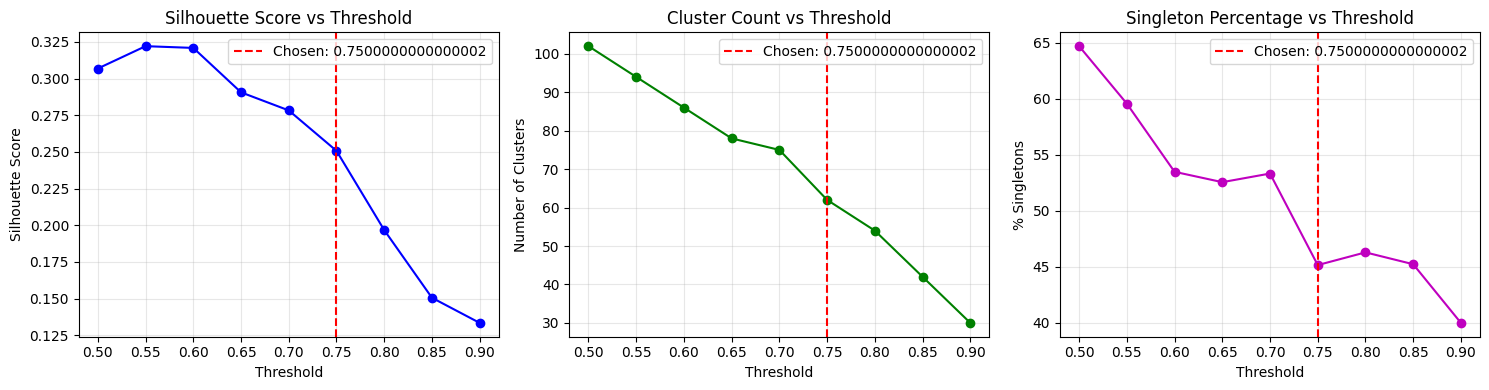

✓ Saved: feature_selection_outputs/threshold_analysis.png


In [0]:
# Plot threshold analysis
threshold_df = pd.DataFrame(threshold_results)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Silhouette scores
axes[0].plot(threshold_df['threshold'], threshold_df['silhouette'], 'bo-')
axes[0].axvline(x=chosen_threshold, color='r', linestyle='--', label=f'Chosen: {chosen_threshold}')
axes[0].set_xlabel('Threshold')
axes[0].set_ylabel('Silhouette Score')
axes[0].set_title('Silhouette Score vs Threshold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Number of clusters
axes[1].plot(threshold_df['threshold'], threshold_df['n_clusters'], 'go-')
axes[1].axvline(x=chosen_threshold, color='r', linestyle='--', label=f'Chosen: {chosen_threshold}')
axes[1].set_xlabel('Threshold')
axes[1].set_ylabel('Number of Clusters')
axes[1].set_title('Cluster Count vs Threshold')
axes[1].legend()
axes[1].grid(alpha=0.3)

# Singleton percentage
axes[2].plot(threshold_df['threshold'], threshold_df['pct_singletons'], 'mo-')
axes[2].axvline(x=chosen_threshold, color='r', linestyle='--', label=f'Chosen: {chosen_threshold}')
axes[2].set_xlabel('Threshold')
axes[2].set_ylabel('% Singletons')
axes[2].set_title('Singleton Percentage vs Threshold')
axes[2].legend()
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'threshold_analysis.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Saved: {OUTPUT_DIR}/threshold_analysis.png")

## Step 1.4: Train Baseline Model (All Features)
 
Train XGBoost model with all features to establish baseline performance.
Evaluation is performed on **train and validation sets only** - test set is held out
until final model evaluation to prevent information leakage during feature selection.

In [0]:
# Check if we can skip this step
if checkpoint_exists("step1_4_baseline_model") and not START_FRESH:
    print_stage("STEP 1.4: TRAIN BASELINE MODEL (from checkpoint)", 4, 7)
    print_progress("Loading from checkpoint: step1_4_baseline_model")
    baseline_checkpoint = load_checkpoint("step1_4_baseline_model")
    baseline_model = baseline_checkpoint['model']
    baseline_metrics = baseline_checkpoint['metrics']
    print_progress(f"Loaded baseline model: Val AUPRC = {baseline_metrics['val']['auprc']:.4f}")
else:
    print_stage("STEP 1.4: TRAIN BASELINE MODEL (ALL FEATURES)", 4, 7)

    # Prepare data splits
    train_mask = df_pandas['SPLIT'] == 'train'
    val_mask = df_pandas['SPLIT'] == 'val'
    test_mask = df_pandas['SPLIT'] == 'test'

    X_train = df_pandas.loc[train_mask].copy()
    y_train = df_pandas.loc[train_mask, 'FUTURE_CRC_EVENT'].copy()

    X_val = df_pandas.loc[val_mask].copy()
    y_val = df_pandas.loc[val_mask, 'FUTURE_CRC_EVENT'].copy()

    X_test = df_pandas.loc[test_mask].copy()
    y_test = df_pandas.loc[test_mask, 'FUTURE_CRC_EVENT'].copy()

    print(f"Training baseline model with {len(feature_cols)} features...")
    print(f"  Train: {len(y_train):,} obs, {y_train.sum():,} events")
    print(f"  Val: {len(y_val):,} obs, {y_val.sum():,} events")
    print(f"  Test: {len(y_test):,} obs, {y_test.sum():,} events")

    start = time.time()
    baseline_model = train_xgboost_model(
        X_train, y_train, X_val, y_val,
        feature_cols, scale_pos_weight
    )
    elapsed = time.time() - start
    print(f"✓ Model trained in {elapsed:.1f}s (best iteration: {baseline_model.best_iteration})")

    # Evaluate on train/val only (test is held out until final evaluation)
    print("\nBaseline performance:")
    baseline_metrics = {
        'train': evaluate_model(baseline_model, X_train, y_train, feature_cols, "Train"),
        'val': evaluate_model(baseline_model, X_val, y_val, feature_cols, "Val")
    }

    # Calculate train-val gap
    baseline_metrics['train_val_gap'] = baseline_metrics['train']['auprc'] - baseline_metrics['val']['auprc']
    print(f"  Train-Val Gap: {baseline_metrics['train_val_gap']:.4f}")
    print("  (Test set held out - evaluated only at final model)")

    # Save checkpoint
    save_checkpoint("step1_4_baseline_model", {
        'model': baseline_model,
        'metrics': baseline_metrics
    })

    # Update tracking CSV
    update_tracking_csv({
        'phase': 'phase1',
        'iteration': 'baseline',
        'n_features': len(feature_cols),
        'n_removed': 0,
        'train_auprc': baseline_metrics['train']['auprc'],
        'val_auprc': baseline_metrics['val']['auprc'],
        'train_val_gap': baseline_metrics['train_val_gap'],
        'val_drop_from_baseline': 0.0,
        'timestamp': datetime.now().isoformat()
    })

print(f"\n✓ Baseline model ready: Val AUPRC = {baseline_metrics['val']['auprc']:.4f}")



[18:57:08] STAGE 4/7: STEP 1.4: TRAIN BASELINE MODEL (ALL FEATURES)
Training baseline model with 166 features...
  Train: 601,647 obs, 2,137 events
  Val: 128,051 obs, 502 events
  Test: 128,613 obs, 453 events
  [18:57:09] Training XGBoost with 166 features...
  [18:57:09] Train: 601,647 obs, 2,137 events | Val: 128,051 obs, 502 events


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run youthful-ram-159 at: https://adb-2845170968234247.7.azuredatabricks.net/ml/experiments/7b6f512c605b4f1a9990c2f59e14c59f/runs/e77c96dea22844ae98ca5f5db1b7420d
🧪 View experiment at: https://adb-2845170968234247.7.azuredatabricks.net/ml/experiments/7b6f512c605b4f1a9990c2f59e14c59f
  [19:04:36] Model trained in 447.6s (best iteration: 147)
✓ Model trained in 447.6s (best iteration: 147)

Baseline performance:
  Train: AUPRC=0.0636 (17.9x lift), AUROC=0.7677
  Val: AUPRC=0.0650 (16.6x lift), AUROC=0.7664
  Train-Val Gap: -0.0014
  (Test set held out - evaluated only at final model)
✓ CHECKPOINT SAVED: step1_4_baseline_model
  ✓ Tracking CSV updated: feature_selection_outputs/iteration_tracking.csv

✓ Baseline model ready: Val AUPRC = 0.0650


## Step 1.5: Compute SHAP with 2:1 Positive Weighting
 
### Why SHAP is Computed on Validation Data
 
We compute SHAP values on the validation set rather than the training set for two reasons:
 
1. **Avoid overfitting to training quirks**: SHAP on training data would reflect feature
   contributions to training patterns, including any noise the model memorized. Validation
   data provides a cleaner signal of generalizable feature importance.
 
2. **Consistent with early stopping**: The model was trained with early stopping on validation
   performance, so its learned structure is already optimized for validation. SHAP on
   validation reflects the models actual generalization behavior.
 
**Tradeoff**: The validation set has fewer positive cases (~1/4 of training: 502 vs 2,137), so importance
estimates have higher variance for rare features. We mitigate this by keeping all positive
cases in the SHAP computation.

In [0]:
# Check if we can skip this step
if checkpoint_exists("step1_5_shap_phase1") and not START_FRESH:
    print_stage("STEP 1.5: COMPUTE SHAP VALUES (from checkpoint)", 5, 7)
    print_progress("Loading from checkpoint: step1_5_shap_phase1")
    shap_checkpoint = load_checkpoint("step1_5_shap_phase1")
    importance_df = shap_checkpoint['importance_df']
    print_progress(f"Loaded SHAP importance for {len(importance_df)} features")
else:
    print_stage("STEP 1.5: COMPUTE SHAP VALUES (2:1 POSITIVE WEIGHTING)", 5, 7)
    print_progress("NOTE: SHAP computation is the slowest step - may take 10-30+ minutes")

    # Use validation set for SHAP
    val_mask = df_pandas['SPLIT'] == 'val'
    X_val = df_pandas.loc[val_mask].copy()
    y_val = df_pandas.loc[val_mask, 'FUTURE_CRC_EVENT'].copy()

    importance_df = compute_shap_values(baseline_model, X_val, y_val, feature_cols)

    # Display top features
    print("\nTop 20 features by SHAP_Combined:")
    print(importance_df[['Rank', 'Feature', 'SHAP_Combined', 'SHAP_Ratio']].head(20).to_string(index=False))

    # Save checkpoint
    save_checkpoint("step1_5_shap_phase1", {
        'importance_df': importance_df
    })

print(f"\n✓ SHAP values computed for {len(importance_df)} features")



[19:12:00] STAGE 5/7: STEP 1.5: COMPUTE SHAP VALUES (2:1 POSITIVE WEIGHTING)
  [19:12:00] NOTE: SHAP computation is the slowest step - may take 10-30+ minutes
  [19:12:00] Starting SHAP computation...
  [19:12:00] Positive cases: 502 | Negative cases: 127,549
  [19:12:00] Creating TreeExplainer...


[19:12:00] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


  [19:12:01] Computing SHAP for 502 positive cases (this may take a while)...
  [19:12:01] Positive cases complete in 0.4s (1298 cases/sec)
  [19:12:01] Sampling 50,000 from 127,549 negative cases for SHAP...
  [19:12:01] Computing SHAP for 50,000 negative cases...
  [19:12:27] Negative cases complete in 25.7s (1945 cases/sec)
  [19:12:27] Calculating importance metrics...
  [19:12:27] SHAP computation complete in 26.3s total

Top 20 features by SHAP_Combined:
 Rank                            Feature  SHAP_Combined  SHAP_Ratio
    1        vit_MAX_WEIGHT_LOSS_PCT_60D       0.056856    1.299620
    2             vit_SBP_VARIABILITY_6M       0.051273    1.227477
    3            icd_SYMPTOM_BURDEN_12MO       0.044547    1.242402
    4            vit_vital_recency_score       0.043782    1.236040
    5                 vit_RECENCY_WEIGHT       0.039322    1.158456
    6       visit_outpatient_visits_12mo       0.036081    1.194300
    7    visit_gi_symptom_op_visits_12mo       0.029703    

## Step 1.6: Select Cluster Representatives

In [0]:
# Check if we can skip this step
if checkpoint_exists("step1_6_cluster_representatives") and not START_FRESH:
    print_stage("STEP 1.6: SELECT CLUSTER REPRESENTATIVES (from checkpoint)", 6, 7)
    print_progress("Loading from checkpoint: step1_6_cluster_representatives")
    rep_checkpoint = load_checkpoint("step1_6_cluster_representatives")
    selected_features = rep_checkpoint['selected_features']
    selection_df = rep_checkpoint['selection_df']
    print_progress(f"Loaded {len(selected_features)} selected features")
else:
    print_stage("STEP 1.6: SELECT CLUSTER REPRESENTATIVES", 6, 7)

    # Identify which clinical must-keep features exist in the data
    valid_must_keep = [f for f in CLINICAL_MUST_KEEP_FEATURES if f in feature_cols]
    missing_must_keep = [f for f in CLINICAL_MUST_KEEP_FEATURES if f not in feature_cols]

    if missing_must_keep:
        print(f"⚠ Clinical must-keep features not found in data: {missing_must_keep}")
    print(f"Clinical must-keep features to preserve: {len(valid_must_keep)}")

    # Merge cluster assignments with SHAP importance
    cluster_importance = cluster_df.merge(importance_df, on='Feature')

    selected_features = []
    selection_records = []

    # For each cluster, select representative(s)
    for cluster_id in sorted(cluster_importance['Cluster'].unique()):
        cluster_features = cluster_importance[cluster_importance['Cluster'] == cluster_id].copy()
        cluster_size = len(cluster_features)

        # Sort by importance_ratio (descending) - prefer features predictive of positives
        cluster_features = cluster_features.sort_values('SHAP_Ratio', ascending=False)

        # Determine how many to keep (adaptive: drop at most 1-2 per cluster)
        if cluster_size <= 2:
            n_keep = cluster_size  # Keep all for tiny clusters
        elif cluster_size <= 4:
            n_keep = cluster_size - 1  # Drop at most 1
        else:
            n_keep = cluster_size - 2  # Drop at most 2 for larger clusters

        # Select top feature(s)
        kept = cluster_features.head(n_keep)

        for _, row in kept.iterrows():
            selected_features.append(row['Feature'])
            selection_records.append({
                'Feature': row['Feature'],
                'Cluster': cluster_id,
                'Cluster_Size': cluster_size,
                'SHAP_Combined': row['SHAP_Combined'],
                'SHAP_Ratio': row['SHAP_Ratio'],
                'Selection_Reason': f"Top by SHAP_Ratio in cluster of {cluster_size}"
            })

    # Add clinical must-keep features that weren't already selected
    for feat in valid_must_keep:
        if feat not in selected_features:
            # Get the feature's importance info
            feat_info = importance_df[importance_df['Feature'] == feat]
            feat_cluster = cluster_df[cluster_df['Feature'] == feat]['Cluster'].values[0]

            selected_features.append(feat)
            selection_records.append({
                'Feature': feat,
                'Cluster': feat_cluster,
                'Cluster_Size': len(cluster_df[cluster_df['Cluster'] == feat_cluster]),
                'SHAP_Combined': feat_info['SHAP_Combined'].values[0] if len(feat_info) > 0 else 0,
                'SHAP_Ratio': feat_info['SHAP_Ratio'].values[0] if len(feat_info) > 0 else 0,
                'Selection_Reason': "Clinical must-keep feature"
            })
            print(f"  + Added clinical must-keep: {feat}")

    selection_df = pd.DataFrame(selection_records)

    print(f"\nCluster representative selection:")
    print(f"  Original features: {len(feature_cols)}")
    print(f"  Clusters: {len(cluster_importance['Cluster'].unique())}")
    print(f"  Selected features: {len(selected_features)}")
    print(f"  Reduction: {len(feature_cols) - len(selected_features)} features removed ({(len(feature_cols) - len(selected_features))/len(feature_cols)*100:.1f}%)")

    # Show selection summary by cluster size
    print("\nSelection by cluster size:")
    for size_cat in ['1', '2-3', '4-7', '8+']:
        if size_cat == '1':
            mask = selection_df['Cluster_Size'] == 1
        elif size_cat == '2-3':
            mask = (selection_df['Cluster_Size'] >= 2) & (selection_df['Cluster_Size'] <= 3)
        elif size_cat == '4-7':
            mask = (selection_df['Cluster_Size'] >= 4) & (selection_df['Cluster_Size'] <= 7)
        else:
            mask = selection_df['Cluster_Size'] >= 8

        n_selected = mask.sum()
        if n_selected > 0:
            print(f"  Cluster size {size_cat}: {n_selected} features selected")

    # Save checkpoint
    save_checkpoint("step1_6_cluster_representatives", {
        'selected_features': selected_features,
        'selection_df': selection_df
    })

print(f"\n✓ Selected {len(selected_features)} cluster representatives")


[19:12:27] STAGE 6/7: STEP 1.6: SELECT CLUSTER REPRESENTATIVES
⚠ Clinical must-keep features not found in data: ['HAS_RAPID_WEIGHT_LOSS', 'MAX_WEIGHT_LOSS_PCT_60D', 'WEIGHT_LOSS_FLAG_6M', 'HAS_GI_BLEEDING', 'HAS_RECTAL_BLEEDING', 'HAS_IRON_DEFICIENCY_ANEMIA', 'HEMOGLOBIN_LATEST', 'AGE', 'HAS_BOWEL_HABIT_CHANGE']
Clinical must-keep features to preserve: 0

Cluster representative selection:
  Original features: 166
  Clusters: 62
  Selected features: 142
  Reduction: 24 features removed (14.5%)

Selection by cluster size:
  Cluster size 1: 28 features selected
  Cluster size 2-3: 48 features selected
  Cluster size 4-7: 21 features selected
  Cluster size 8+: 45 features selected
✓ CHECKPOINT SAVED: step1_6_cluster_representatives

✓ Selected 142 cluster representatives


## Step 1.7: Phase 1 Validation Gate

In [0]:
# Check if we can skip this step
if checkpoint_exists("step1_7_phase1_complete") and not START_FRESH:
    print_stage("STEP 1.7: PHASE 1 VALIDATION GATE (from checkpoint)", 7, 7)
    print_progress("Loading from checkpoint: step1_7_phase1_complete")
    phase1_checkpoint = load_checkpoint("step1_7_phase1_complete")
    phase1_features = phase1_checkpoint['phase1_features']
    phase1_metrics = phase1_checkpoint['phase1_metrics']
    phase1_passed = phase1_checkpoint['phase1_passed']
    print_progress(f"Phase 1 complete: {len(phase1_features)} features, passed={phase1_passed}")
else:
    print_stage("STEP 1.7: PHASE 1 VALIDATION GATE", 7, 7)

    # Prepare data
    train_mask = df_pandas['SPLIT'] == 'train'
    val_mask = df_pandas['SPLIT'] == 'val'
    test_mask = df_pandas['SPLIT'] == 'test'

    X_train = df_pandas.loc[train_mask].copy()
    y_train = df_pandas.loc[train_mask, 'FUTURE_CRC_EVENT'].copy()

    X_val = df_pandas.loc[val_mask].copy()
    y_val = df_pandas.loc[val_mask, 'FUTURE_CRC_EVENT'].copy()

    X_test = df_pandas.loc[test_mask].copy()
    y_test = df_pandas.loc[test_mask, 'FUTURE_CRC_EVENT'].copy()

    print(f"Training model with {len(selected_features)} selected features...")

    # Train model with selected features
    phase1_model = train_xgboost_model(
        X_train, y_train, X_val, y_val,
        selected_features, scale_pos_weight
    )

    # Evaluate on train/val only (test is held out until final evaluation)
    print("\nPhase 1 reduced model performance:")
    phase1_metrics = {
        'train': evaluate_model(phase1_model, X_train, y_train, selected_features, "Train"),
        'val': evaluate_model(phase1_model, X_val, y_val, selected_features, "Val")
    }

    phase1_metrics['train_val_gap'] = phase1_metrics['train']['auprc'] - phase1_metrics['val']['auprc']

    # Calculate drops from baseline
    val_drop = (baseline_metrics['val']['auprc'] - phase1_metrics['val']['auprc']) / baseline_metrics['val']['auprc']
    gap_change = phase1_metrics['train_val_gap'] - baseline_metrics['train_val_gap']

    print(f"\nValidation Gate Check:")
    print(f"  Baseline Val AUPRC: {baseline_metrics['val']['auprc']:.4f}")
    print(f"  Phase 1 Val AUPRC:  {phase1_metrics['val']['auprc']:.4f}")
    print(f"  Val AUPRC Drop:     {val_drop*100:.2f}% (threshold: {PHASE1_MAX_VAL_DROP*100}%)")
    print(f"  Train-Val Gap Change: {gap_change:.4f}")

    # Check if passed
    phase1_passed = val_drop <= PHASE1_MAX_VAL_DROP

    if phase1_passed:
        print(f"\n✓ PHASE 1 VALIDATION GATE: PASSED")
        phase1_features = selected_features
    else:
        print(f"\n⚠ PHASE 1 VALIDATION GATE: FAILED")
        print("  Consider: keeping top 2 per cluster, or raising threshold")
        # For now, proceed with selected features but flag the issue
        phase1_features = selected_features

    # Save checkpoint
    save_checkpoint("step1_7_phase1_complete", {
        'phase1_features': phase1_features,
        'phase1_metrics': phase1_metrics,
        'phase1_passed': phase1_passed,
        'val_drop': val_drop,
        'gap_change': gap_change
    })

    # Update tracking CSV
    update_tracking_csv({
        'phase': 'phase1',
        'iteration': 'cluster_reduction',
        'n_features': len(phase1_features),
        'n_removed': len(feature_cols) - len(phase1_features),
        'train_auprc': phase1_metrics['train']['auprc'],
        'val_auprc': phase1_metrics['val']['auprc'],
        'train_val_gap': phase1_metrics['train_val_gap'],
        'val_drop_from_baseline': val_drop,
        'timestamp': datetime.now().isoformat()
    })

print(f"\n✓ Phase 1 complete: {len(phase1_features)} features")


[19:12:28] STAGE 7/7: STEP 1.7: PHASE 1 VALIDATION GATE
Training model with 142 selected features...
  [19:12:29] Training XGBoost with 142 features...
  [19:12:29] Train: 601,647 obs, 2,137 events | Val: 128,051 obs, 502 events


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run funny-gnu-846 at: https://adb-2845170968234247.7.azuredatabricks.net/ml/experiments/7b6f512c605b4f1a9990c2f59e14c59f/runs/a93582888aff4ecbb8d9a27f48a2a028
🧪 View experiment at: https://adb-2845170968234247.7.azuredatabricks.net/ml/experiments/7b6f512c605b4f1a9990c2f59e14c59f
  [19:21:01] Model trained in 512.5s (best iteration: 40)

Phase 1 reduced model performance:
  Train: AUPRC=0.0674 (19.0x lift), AUROC=0.7647
  Val: AUPRC=0.0732 (18.7x lift), AUROC=0.7705

Validation Gate Check:
  Baseline Val AUPRC: 0.0650
  Phase 1 Val AUPRC:  0.0732
  Val AUPRC Drop:     -12.66% (threshold: 10.0%)
  Train-Val Gap Change: -0.0044

✓ PHASE 1 VALIDATION GATE: PASSED
✓ CHECKPOINT SAVED: step1_7_phase1_complete
  ✓ Tracking CSV updated: feature_selection_outputs/iteration_tracking.csv

✓ Phase 1 complete: 142 features


---
# PHASE 2: Iterative SHAP Winnowing
---
 
Iteratively remove low-importance features while monitoring validation performance.
 
**Key controls:**
- **Stop conditions**: Stops when hitting minimum feature threshold (25) or no features meet 2+ removal criteria
- **Clinical must-keep**: Never remove clinically important features (weight loss, GI bleeding, etc.)
- **High-importance cluster protection**: Clusters in top 20% by max SHAP limited to 1 removal
- **Test tracked but not used**: Test metrics logged at every iteration for post-hoc analysis; all removal decisions based on SHAP importance only

## Phase 2 Iteration Loop

In [0]:
print_stage("PHASE 2: ITERATIVE SHAP WINNOWING")

# Initialize Phase 2
current_features = phase1_features.copy()
iteration = 0
stop_reason = None
prev_metrics = phase1_metrics.copy()  # Track previous iteration for comparison

# Check for existing Phase 2 checkpoints to resume
phase2_checkpoints = [cp for cp in list_checkpoints() if cp.startswith("step2_iter") and cp.endswith("_complete")]
if phase2_checkpoints and not START_FRESH:
    # Find the latest complete iteration
    iter_nums = []
    for cp in phase2_checkpoints:
        try:
            iter_num = int(cp.split("_")[1].replace("iter", ""))
            iter_nums.append(iter_num)
        except:
            pass

    if iter_nums:
        last_iter = max(iter_nums)
        print_progress(f"Found Phase 2 checkpoint at iteration {last_iter}. Resuming...")

        last_checkpoint = load_checkpoint(f"step2_iter{last_iter}_complete")
        current_features = last_checkpoint['current_features']
        iteration = last_iter

        # Update prev_metrics from checkpoint for comparison
        if 'metrics' in last_checkpoint:
            prev_metrics = last_checkpoint['metrics'].copy()

        # Check if we should stop
        if last_checkpoint.get('stop_triggered', False):
            stop_reason = last_checkpoint.get('stop_reason', 'Unknown')
            print_progress(f"Previous iteration triggered stop: {stop_reason}")

print_progress(f"Starting Phase 2 from iteration {iteration}")
print_progress(f"Current features: {len(current_features)}")
print_progress(f"Max removals: {MAX_REMOVALS_EARLY} (iter 1-{LATE_PHASE_ITERATION}), {MAX_REMOVALS_LATE} (iter {LATE_PHASE_ITERATION+1}+)")
print_progress(f"Min features threshold: {MIN_FEATURES_THRESHOLD}")
print_progress("Each iteration: Train model → Compute SHAP → Identify removals → Validate")
print("="*70)


[19:29:38] PHASE 2: ITERATIVE SHAP WINNOWING
  [19:29:39] Starting Phase 2 from iteration 0
  [19:29:39] Current features: 142
  [19:29:39] Max removals: 10 (iter 1-5), 5 (iter 6+)
  [19:29:39] Min features threshold: 25
  [19:29:39] Each iteration: Train model → Compute SHAP → Identify removals → Validate


## Run Phase 2 Iterations

In [0]:
# Prepare data splits (needed for iterations)
train_mask = df_pandas['SPLIT'] == 'train'
val_mask = df_pandas['SPLIT'] == 'val'
test_mask = df_pandas['SPLIT'] == 'test'

X_train = df_pandas.loc[train_mask].copy()
y_train = df_pandas.loc[train_mask, 'FUTURE_CRC_EVENT'].copy()

X_val = df_pandas.loc[val_mask].copy()
y_val = df_pandas.loc[val_mask, 'FUTURE_CRC_EVENT'].copy()

X_test = df_pandas.loc[test_mask].copy()
y_test = df_pandas.loc[test_mask, 'FUTURE_CRC_EVENT'].copy()

# Main iteration loop
while stop_reason is None:
    iteration += 1
    iter_start_time = time.time()

    # Determine max removals for this iteration (gradual reduction)
    max_removals_this_iter = MAX_REMOVALS_EARLY if iteration <= LATE_PHASE_ITERATION else MAX_REMOVALS_LATE

    print_stage(f"PHASE 2 - ITERATION {iteration}")
    print_progress(f"Current features: {len(current_features)}")
    print_progress(f"Target: Remove up to {max_removals_this_iter} low-value features")

    # =========================================================================
    # Step 2.1: Train Model
    # =========================================================================
    checkpoint_name = f"step2_iter{iteration}_model"

    if checkpoint_exists(checkpoint_name) and not START_FRESH:
        print_progress(f"Step 2.{iteration}.1: Loading model from checkpoint...")
        model_checkpoint = load_checkpoint(checkpoint_name)
        iter_model = model_checkpoint['model']
        iter_metrics = model_checkpoint['metrics']
        # Evaluate test if not in checkpoint (for older checkpoints)
        if 'test' not in iter_metrics:
            iter_metrics['test'] = evaluate_model(iter_model, X_test, y_test, current_features, "Test")
        print_progress(f"Model loaded: Val AUPRC = {iter_metrics['val']['auprc']:.4f}, Test AUPRC = {iter_metrics['test']['auprc']:.4f}")
    else:
        print_progress(f"Step 2.{iteration}.1: Training model with {len(current_features)} features...")

        iter_model = train_xgboost_model(
            X_train, y_train, X_val, y_val,
            current_features, scale_pos_weight
        )

        iter_metrics = {
            'train': evaluate_model(iter_model, X_train, y_train, current_features, "Train"),
            'val': evaluate_model(iter_model, X_val, y_val, current_features, "Val"),
            'test': evaluate_model(iter_model, X_test, y_test, current_features, "Test")  # Track for post-hoc analysis
        }
        iter_metrics['train_val_gap'] = iter_metrics['train']['auprc'] - iter_metrics['val']['auprc']
        print(f"  Test AUPRC: {iter_metrics['test']['auprc']:.4f} (tracking only - not used for decisions)")

        save_checkpoint(checkpoint_name, {
            'model': iter_model,
            'metrics': iter_metrics
        })

    # =========================================================================
    # Step 2.2: Compute SHAP
    # =========================================================================
    checkpoint_name = f"step2_iter{iteration}_shap"

    if checkpoint_exists(checkpoint_name) and not START_FRESH:
        print_progress(f"Step 2.{iteration}.2: Loading SHAP values from checkpoint...")
        shap_checkpoint = load_checkpoint(checkpoint_name)
        iter_importance_df = shap_checkpoint['importance_df']
        print_progress(f"SHAP loaded for {len(iter_importance_df)} features")
    else:
        print_progress(f"Step 2.{iteration}.2: Computing SHAP values (this is the slow step)...")

        iter_importance_df = compute_shap_values(iter_model, X_val, y_val, current_features)

        save_checkpoint(checkpoint_name, {
            'importance_df': iter_importance_df
        })

    # =========================================================================
    # Step 2.3: Identify Removal Candidates (ORIGINAL METHODOLOGY)
    # =========================================================================
    # From CRC_ITER1_MODEL-PREVALENCE.py:
    # Feature must meet AT LEAST 2 of 3 criteria:
    #   1. Near-zero SHAP importance (< ZERO_SHAP_THRESHOLD)
    #   2. Negative-biased ratio (< NEG_BIAS_RATIO_THRESHOLD)
    #   3. Bottom percentile by SHAP (< BOTTOM_PERCENTILE)
    #
    # Cluster-specific removal caps:
    #   - Singleton (1): max 1 removal
    #   - Small (2-3): max 2 removals, leave at least 1
    #   - Medium (4-7): max 2 removals, leave at least 3
    #   - Large (8+): max 3 removals, leave at least 5
    #   - High-importance clusters (top 20%): max 1 removal
    # =========================================================================
    print_progress(f"Step 2.{iteration}.3: Identifying removal candidates (original methodology)...")

    n_features = len(current_features)

    # Get cluster assignments for current features
    current_selection = selection_df[selection_df['Feature'].isin(current_features)].copy()

    # Merge SHAP importance with cluster info
    iter_importance_with_cluster = iter_importance_df.merge(
        current_selection[['Feature', 'Cluster']],
        on='Feature',
        how='left'
    )

    # Clinical must-keep features are always protected
    clinical_protected = set(f for f in CLINICAL_MUST_KEEP_FEATURES if f in current_features)

    # -------------------------------------------------------------------------
    # Calculate features meeting each criterion
    # -------------------------------------------------------------------------
    zero_importance_features = set(
        iter_importance_df[iter_importance_df['SHAP_Combined'] < ZERO_SHAP_THRESHOLD]['Feature']
    )
    neg_biased_features = set(
        iter_importance_df[iter_importance_df['SHAP_Ratio'] < NEG_BIAS_RATIO_THRESHOLD]['Feature']
    )
    importance_percentile = iter_importance_df['SHAP_Combined'].quantile(BOTTOM_PERCENTILE / 100)
    bottom_features = set(
        iter_importance_df[iter_importance_df['SHAP_Combined'] < importance_percentile]['Feature']
    )

    # Feature must meet AT LEAST 2 of 3 criteria
    features_meeting_two_criteria = (
        (zero_importance_features & neg_biased_features) |
        (zero_importance_features & bottom_features) |
        (neg_biased_features & bottom_features)
    )
    features_meeting_all = zero_importance_features & neg_biased_features & bottom_features

    # Remove clinical protected from candidates
    features_flagged = features_meeting_two_criteria - clinical_protected

    print(f"  Removal criteria:")
    print(f"    Near-zero SHAP (<{ZERO_SHAP_THRESHOLD}): {len(zero_importance_features)}")
    print(f"    Negative-biased (<{NEG_BIAS_RATIO_THRESHOLD}): {len(neg_biased_features)}")
    print(f"    Bottom {BOTTOM_PERCENTILE}% (threshold={importance_percentile:.6f}): {len(bottom_features)}")
    print(f"    Meeting ALL 3 criteria: {len(features_meeting_all)}")
    print(f"    Meeting 2+ criteria: {len(features_meeting_two_criteria)}")
    print(f"    Flagged (excl. clinical): {len(features_flagged)}")

    # -------------------------------------------------------------------------
    # Analyze flagged features by cluster with removal caps
    # -------------------------------------------------------------------------
    # IMPORTANT: Use ORIGINAL cluster sizes from Phase 1 (stored in selection_df)
    # not current sizes. This matches the original methodology which reads from
    # the cluster CSV file each iteration.
    # -------------------------------------------------------------------------

    # Get original cluster sizes from selection_df (created in Phase 1)
    original_cluster_sizes = selection_df.groupby('Cluster')['Cluster_Size'].first().to_dict()

    cluster_removal_candidates = {}

    for cluster_id in iter_importance_with_cluster['Cluster'].dropna().unique():
        cluster_features = iter_importance_with_cluster[iter_importance_with_cluster['Cluster'] == cluster_id]

        # Use ORIGINAL cluster size, not current size
        cluster_size = original_cluster_sizes.get(cluster_id, len(cluster_features))

        # Find flagged features in this cluster
        flagged_in_cluster = list(set(cluster_features['Feature'].tolist()) & features_flagged)

        if not flagged_in_cluster:
            continue

        # Get SHAP scores for flagged features
        flagged_with_scores = []
        for feat in flagged_in_cluster:
            feat_row = iter_importance_df[iter_importance_df['Feature'] == feat]
            if len(feat_row) > 0:
                shap_val = feat_row['SHAP_Combined'].values[0]
                ratio_val = feat_row['SHAP_Ratio'].values[0]
                meets_all = feat in features_meeting_all
                flagged_with_scores.append((feat, shap_val, ratio_val, meets_all))

        # Sort by: (1) meets all criteria first, then (2) SHAP score ascending
        flagged_with_scores.sort(key=lambda x: (not x[3], x[1]))

        cluster_removal_candidates[cluster_id] = {
            'size': cluster_size,  # Original size from Phase 1
            'current_size': len(cluster_features),  # Current size for logging
            'flagged': flagged_with_scores,
            'max_shap': cluster_features['SHAP_Combined'].max()
        }

    # -------------------------------------------------------------------------
    # Apply cluster removal rules (from original methodology)
    # -------------------------------------------------------------------------
    removals_by_priority = []
    shap_80th = iter_importance_df['SHAP_Combined'].quantile(0.80)

    for cluster_id, cluster_info in cluster_removal_candidates.items():
        cluster_size = cluster_info['size']
        flagged_list = cluster_info['flagged']
        max_shap = cluster_info['max_shap']

        # Cluster-specific removal caps
        if cluster_size == 1:
            max_remove = 1  # Singleton - can remove if flagged
        elif cluster_size <= 3:
            max_remove = min(2, cluster_size - 1)  # Small - max 2, leave at least 1
        elif cluster_size <= 7:
            max_remove = min(2, cluster_size - 3) if cluster_size > 3 else 0  # Medium
        else:
            max_remove = min(3, cluster_size - 5) if cluster_size > 5 else 0  # Large

        # Additional protection for high-importance clusters
        if max_shap > shap_80th:
            max_remove = min(max_remove, 1)

        # Select worst features up to limit
        for i, (feat, shap_val, ratio_val, meets_all) in enumerate(flagged_list[:max_remove]):
            priority_score = shap_val * 1000 + (0 if meets_all else 1)
            removals_by_priority.append((feat, shap_val, ratio_val, cluster_id, cluster_size, priority_score))

    # Sort by priority score and apply global limit (iteration-aware)
    removals_by_priority.sort(key=lambda x: x[5])
    final_removals = removals_by_priority[:max_removals_this_iter]

    features_to_remove = [feat for feat, _, _, _, _, _ in final_removals]

    # Summary statistics
    print(f"\n  Cluster-aware removal:")
    print(f"    Total flagged across clusters: {len(removals_by_priority)}")
    print(f"    After global cap ({max_removals_this_iter}): {len(features_to_remove)}")
    print(f"    Clinical protected: {len(clinical_protected)}")

    if features_to_remove:
        print(f"\n  Features to remove ({len(features_to_remove)}):")
        for feat, shap_val, ratio_val, cluster_id, cluster_size, _ in final_removals[:10]:
            print(f"    - {feat:<45} SHAP={shap_val:.6f}, Ratio={ratio_val:.3f}, Cluster {cluster_id} (size={cluster_size})")
        if len(final_removals) > 10:
            print(f"    ... and {len(final_removals) - 10} more")

    # =========================================================================
    # Step 2.4: Validation Gate
    # =========================================================================
    print_progress(f"Step 2.{iteration}.4: Checking validation gates...")

    # Track metrics for post-hoc analysis (NOT used for stopping decisions)
    val_change = iter_metrics['val']['auprc'] - prev_metrics['val']['auprc']
    test_change = iter_metrics['test']['auprc'] - prev_metrics.get('test', {}).get('auprc', iter_metrics['test']['auprc'])
    val_drop_from_baseline = (baseline_metrics['val']['auprc'] - iter_metrics['val']['auprc']) / baseline_metrics['val']['auprc']

    print(f"  Val AUPRC:  {iter_metrics['val']['auprc']:.4f} (change: {val_change:+.4f})")
    print(f"  Test AUPRC: {iter_metrics['test']['auprc']:.4f} (change: {test_change:+.4f})")
    print(f"  Train-Val Gap: {iter_metrics['train_val_gap']:.4f}")
    print(f"  Features remaining: {len(current_features)}")

    # Simple stop conditions - run until we hit limits
    # Metrics are tracked but NOT used to influence stopping
    if len(current_features) - len(features_to_remove) < MIN_FEATURES_THRESHOLD:
        stop_reason = f"Would go below {MIN_FEATURES_THRESHOLD} features"
    elif len(features_to_remove) == 0:
        stop_reason = "No features meet removal criteria"

    # =========================================================================
    # Step 2.5: Log & Checkpoint
    # =========================================================================

    # Update tracking CSV - includes test for post-hoc sweet spot analysis
    update_tracking_csv({
        'phase': 'phase2',
        'iteration': iteration,
        'n_features': len(current_features),
        'n_removed': len(features_to_remove) if stop_reason is None else 0,
        'train_auprc': iter_metrics['train']['auprc'],
        'val_auprc': iter_metrics['val']['auprc'],
        'test_auprc': iter_metrics['test']['auprc'],
        'train_val_gap': iter_metrics['train_val_gap'],
        'val_change_from_prev': val_change,
        'test_change_from_prev': test_change,
        'val_drop_from_baseline': val_drop_from_baseline,
        'stop_triggered': stop_reason is not None,
        'stop_reason': stop_reason if stop_reason else '',
        'timestamp': datetime.now().isoformat()
    })

    if stop_reason:
        print(f"\n>>> STOP CONDITION TRIGGERED: {stop_reason}")
        print(f">>> Keeping features from iteration {iteration}")

        # Save final checkpoint
        save_checkpoint(f"step2_iter{iteration}_complete", {
            'current_features': current_features,
            'metrics': iter_metrics,
            'features_removed': [],
            'stop_triggered': True,
            'stop_reason': stop_reason
        })
        break
    else:
        # Remove features and continue
        print(f"\n>>> Removing {len(features_to_remove)} features:")
        for feat in features_to_remove[:10]:
            shap_val = iter_importance_df[iter_importance_df['Feature'] == feat]['SHAP_Combined'].values[0]
            ratio_val = iter_importance_df[iter_importance_df['Feature'] == feat]['SHAP_Ratio'].values[0]
            print(f"    - {feat} (SHAP={shap_val:.6f}, Ratio={ratio_val:.3f})")
        if len(features_to_remove) > 10:
            print(f"    ... and {len(features_to_remove) - 10} more")

        # Update feature list
        previous_features = current_features.copy()
        current_features = [f for f in current_features if f not in features_to_remove]

        # Save checkpoint
        save_checkpoint(f"step2_iter{iteration}_complete", {
            'current_features': current_features,
            'previous_features': previous_features,
            'metrics': iter_metrics,
            'features_removed': features_to_remove,
            'stop_triggered': False,
            'stop_reason': None
        })

        # Update previous metrics for next iteration comparison
        prev_metrics = iter_metrics.copy()

        iter_elapsed = time.time() - iter_start_time
        print_progress(f"Iteration {iteration} complete in {iter_elapsed:.1f}s. Features: {len(previous_features)} → {len(current_features)}")


[19:29:40] PHASE 2 - ITERATION 1
  [19:29:40] Current features: 142
  [19:29:40] Target: Remove up to 10 low-value features
  [19:29:40] Step 2.1.1: Training model with 142 features...
  [19:29:40] Training XGBoost with 142 features...
  [19:29:40] Train: 601,647 obs, 2,137 events | Val: 128,051 obs, 502 events


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run awesome-snake-555 at: https://adb-2845170968234247.7.azuredatabricks.net/ml/experiments/7b6f512c605b4f1a9990c2f59e14c59f/runs/0d08ab3787274bfc9a6e9b0e951545ab
🧪 View experiment at: https://adb-2845170968234247.7.azuredatabricks.net/ml/experiments/7b6f512c605b4f1a9990c2f59e14c59f
  [19:38:07] Model trained in 506.9s (best iteration: 40)
  Train: AUPRC=0.0674 (19.0x lift), AUROC=0.7647
  Val: AUPRC=0.0732 (18.7x lift), AUROC=0.7705
  Test: AUPRC=0.0640 (18.2x lift), AUROC=0.7519
  Test AUPRC: 0.0640 (tracking only - not used for decisions)
✓ CHECKPOINT SAVED: step2_iter1_model
  [19:48:12] Step 2.1.2: Computing SHAP values (this is the slow step)...
  [19:48:12] Starting SHAP computation...
  [19:48:12] Positive cases: 502 | Negative cases: 127,549
  [19:48:12] Creating TreeExplainer...
  [19:48:12] Computing SHAP for 502 positive cases (this may take a while)...


[19:48:12] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


  [19:48:12] Positive cases complete in 0.5s (1054 cases/sec)
  [19:48:12] Sampling 50,000 from 127,549 negative cases for SHAP...
  [19:48:12] Computing SHAP for 50,000 negative cases...
  [19:48:44] Negative cases complete in 31.1s (1605 cases/sec)
  [19:48:44] Calculating importance metrics...
  [19:48:44] SHAP computation complete in 31.8s total
✓ CHECKPOINT SAVED: step2_iter1_shap
  [19:48:44] Step 2.1.3: Identifying removal candidates (original methodology)...
  Removal criteria:
    Near-zero SHAP (<0.0005): 110
    Negative-biased (<0.25): 106
    Bottom 12% (threshold=0.000000): 0
    Meeting ALL 3 criteria: 0
    Meeting 2+ criteria: 106
    Flagged (excl. clinical): 106

  Cluster-aware removal:
    Total flagged across clusters: 63
    After global cap (10): 10
    Clinical protected: 0

  Features to remove (10):
    - vit_abnormal_weight_pattern                   SHAP=0.000000, Ratio=0.000, Cluster 19 (size=2)
    - vit_RAPID_WEIGHT_LOSS_FLAG                    SHAP=0.000

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run likeable-shrimp-468 at: https://adb-2845170968234247.7.azuredatabricks.net/ml/experiments/7b6f512c605b4f1a9990c2f59e14c59f/runs/03b6931c868b4c75b0c85f706906fbf9
🧪 View experiment at: https://adb-2845170968234247.7.azuredatabricks.net/ml/experiments/7b6f512c605b4f1a9990c2f59e14c59f
  [19:57:38] Model trained in 533.6s (best iteration: 57)
  Train: AUPRC=0.0661 (18.6x lift), AUROC=0.7667
  Val: AUPRC=0.0784 (20.0x lift), AUROC=0.7609
  Test: AUPRC=0.0633 (18.0x lift), AUROC=0.7454
  Test AUPRC: 0.0633 (tracking only - not used for decisions)
✓ CHECKPOINT SAVED: step2_iter2_model
  [20:08:05] Step 2.2.2: Computing SHAP values (this is the slow step)...
  [20:08:05] Starting SHAP computation...
  [20:08:05] Positive cases: 502 | Negative cases: 127,549
  [20:08:05] Creating TreeExplainer...
  [20:08:05] Computing SHAP for 502 positive cases (this may take a while)...


[20:08:05] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


  [20:08:06] Positive cases complete in 0.5s (1008 cases/sec)
  [20:08:06] Sampling 50,000 from 127,549 negative cases for SHAP...
  [20:08:06] Computing SHAP for 50,000 negative cases...
  [20:08:39] Negative cases complete in 32.8s (1524 cases/sec)
  [20:08:39] Calculating importance metrics...
  [20:08:39] SHAP computation complete in 33.4s total
✓ CHECKPOINT SAVED: step2_iter2_shap
  [20:08:39] Step 2.2.3: Identifying removal candidates (original methodology)...
  Removal criteria:
    Near-zero SHAP (<0.0005): 102
    Negative-biased (<0.25): 89
    Bottom 12% (threshold=0.000000): 0
    Meeting ALL 3 criteria: 0
    Meeting 2+ criteria: 89
    Flagged (excl. clinical): 89

  Cluster-aware removal:
    Total flagged across clusters: 58
    After global cap (10): 10
    Clinical protected: 0

  Features to remove (10):
    - vit_bp_instability                            SHAP=0.000000, Ratio=0.000, Cluster 34 (size=2)
    - visit_primary_care_continuity_ratio           SHAP=0.000000

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run smiling-foal-262 at: https://adb-2845170968234247.7.azuredatabricks.net/ml/experiments/7b6f512c605b4f1a9990c2f59e14c59f/runs/e119f700a4314b1aa09262d6591e66e6
🧪 View experiment at: https://adb-2845170968234247.7.azuredatabricks.net/ml/experiments/7b6f512c605b4f1a9990c2f59e14c59f
  [20:17:47] Model trained in 547.4s (best iteration: 15)
  Train: AUPRC=0.0540 (15.2x lift), AUROC=0.7523
  Val: AUPRC=0.0644 (16.4x lift), AUROC=0.7550
  Test: AUPRC=0.0369 (10.5x lift), AUROC=0.7201
  Test AUPRC: 0.0369 (tracking only - not used for decisions)
✓ CHECKPOINT SAVED: step2_iter3_model
  [20:28:23] Step 2.3.2: Computing SHAP values (this is the slow step)...
  [20:28:23] Starting SHAP computation...
  [20:28:23] Positive cases: 502 | Negative cases: 127,549
  [20:28:23] Creating TreeExplainer...
  [20:28:23] Computing SHAP for 502 positive cases (this may take a while)...


[20:28:23] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


  [20:28:23] Positive cases complete in 0.5s (1025 cases/sec)
  [20:28:23] Sampling 50,000 from 127,549 negative cases for SHAP...
  [20:28:23] Computing SHAP for 50,000 negative cases...
  [20:28:57] Negative cases complete in 33.2s (1504 cases/sec)
  [20:28:57] Calculating importance metrics...
  [20:28:57] SHAP computation complete in 33.8s total
✓ CHECKPOINT SAVED: step2_iter3_shap
  [20:28:57] Step 2.3.3: Identifying removal candidates (original methodology)...
  Removal criteria:
    Near-zero SHAP (<0.0005): 108
    Negative-biased (<0.25): 102
    Bottom 12% (threshold=0.000000): 0
    Meeting ALL 3 criteria: 0
    Meeting 2+ criteria: 102
    Flagged (excl. clinical): 102

  Cluster-aware removal:
    Total flagged across clusters: 66
    After global cap (10): 10
    Clinical protected: 0

  Features to remove (10):
    - visit_pcp_visits_12mo                         SHAP=0.000000, Ratio=0.000, Cluster 37 (size=10)
    - icd_BLEED_FLAG_12MO                           SHAP=0.00

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run enchanting-skunk-651 at: https://adb-2845170968234247.7.azuredatabricks.net/ml/experiments/7b6f512c605b4f1a9990c2f59e14c59f/runs/71f24b39ae604914a2bf0404d4c06107
🧪 View experiment at: https://adb-2845170968234247.7.azuredatabricks.net/ml/experiments/7b6f512c605b4f1a9990c2f59e14c59f
  [20:37:04] Model trained in 485.6s (best iteration: 6)
  Train: AUPRC=0.0817 (23.0x lift), AUROC=0.7508
  Val: AUPRC=0.1032 (26.3x lift), AUROC=0.7430
  Test: AUPRC=0.1345 (38.2x lift), AUROC=0.7421
  Test AUPRC: 0.1345 (tracking only - not used for decisions)
✓ CHECKPOINT SAVED: step2_iter4_model
  [20:46:42] Step 2.4.2: Computing SHAP values (this is the slow step)...
  [20:46:42] Starting SHAP computation...
  [20:46:42] Positive cases: 502 | Negative cases: 127,549
  [20:46:42] Creating TreeExplainer...
  [20:46:42] Computing SHAP for 502 positive cases (this may take a while)...


[20:46:42] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


  [20:46:42] Positive cases complete in 0.4s (1140 cases/sec)
  [20:46:42] Sampling 50,000 from 127,549 negative cases for SHAP...
  [20:46:42] Computing SHAP for 50,000 negative cases...
  [20:47:12] Negative cases complete in 29.5s (1692 cases/sec)
  [20:47:12] Calculating importance metrics...
  [20:47:12] SHAP computation complete in 30.1s total
✓ CHECKPOINT SAVED: step2_iter4_shap
  [20:47:12] Step 2.4.3: Identifying removal candidates (original methodology)...
  Removal criteria:
    Near-zero SHAP (<0.0005): 100
    Negative-biased (<0.25): 98
    Bottom 12% (threshold=0.000000): 0
    Meeting ALL 3 criteria: 0
    Meeting 2+ criteria: 98
    Flagged (excl. clinical): 98

  Cluster-aware removal:
    Total flagged across clusters: 64
    After global cap (10): 10
    Clinical protected: 0

  Features to remove (10):
    - vit_vital_recency_score                       SHAP=0.000000, Ratio=0.000, Cluster 37 (size=10)
    - icd_ANEMIA_FLAG_12MO                          SHAP=0.00000

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run bald-shrike-709 at: https://adb-2845170968234247.7.azuredatabricks.net/ml/experiments/7b6f512c605b4f1a9990c2f59e14c59f/runs/20f7393eb2f0496a8a451579a54441fb
🧪 View experiment at: https://adb-2845170968234247.7.azuredatabricks.net/ml/experiments/7b6f512c605b4f1a9990c2f59e14c59f
  [20:55:37] Model trained in 504.3s (best iteration: 320)
  Train: AUPRC=0.0738 (20.8x lift), AUROC=0.7830
  Val: AUPRC=0.0833 (21.2x lift), AUROC=0.7809
  Test: AUPRC=0.0864 (24.5x lift), AUROC=0.7655
  Test AUPRC: 0.0864 (tracking only - not used for decisions)
✓ CHECKPOINT SAVED: step2_iter5_model
  [21:05:02] Step 2.5.2: Computing SHAP values (this is the slow step)...
  [21:05:02] Starting SHAP computation...
  [21:05:02] Positive cases: 502 | Negative cases: 127,549
  [21:05:02] Creating TreeExplainer...
  [21:05:02] Computing SHAP for 502 positive cases (this may take a while)...


[21:05:02] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


  [21:05:02] Positive cases complete in 0.4s (1170 cases/sec)
  [21:05:02] Sampling 50,000 from 127,549 negative cases for SHAP...
  [21:05:02] Computing SHAP for 50,000 negative cases...
  [21:05:31] Negative cases complete in 29.0s (1725 cases/sec)
  [21:05:31] Calculating importance metrics...
  [21:05:31] SHAP computation complete in 29.6s total
✓ CHECKPOINT SAVED: step2_iter5_shap
  [21:05:32] Step 2.5.3: Identifying removal candidates (original methodology)...
  Removal criteria:
    Near-zero SHAP (<0.0005): 61
    Negative-biased (<0.25): 43
    Bottom 12% (threshold=0.000000): 0
    Meeting ALL 3 criteria: 0
    Meeting 2+ criteria: 43
    Flagged (excl. clinical): 43

  Cluster-aware removal:
    Total flagged across clusters: 37
    After global cap (10): 10
    Clinical protected: 0

  Features to remove (10):
    - icd_IDA_WITH_BLEEDING                         SHAP=0.000000, Ratio=0.000, Cluster 46 (size=14)
    - inp_med_inp_obstruction_pattern               SHAP=0.000000

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run painted-shark-747 at: https://adb-2845170968234247.7.azuredatabricks.net/ml/experiments/7b6f512c605b4f1a9990c2f59e14c59f/runs/3d38c91d7c724298bcff2a429844072c
🧪 View experiment at: https://adb-2845170968234247.7.azuredatabricks.net/ml/experiments/7b6f512c605b4f1a9990c2f59e14c59f
  [21:13:53] Model trained in 500.4s (best iteration: 6)
  Train: AUPRC=0.0430 (12.1x lift), AUROC=0.7461
  Val: AUPRC=0.0548 (14.0x lift), AUROC=0.7379
  Test: AUPRC=0.0500 (14.2x lift), AUROC=0.7359
  Test AUPRC: 0.0500 (tracking only - not used for decisions)
✓ CHECKPOINT SAVED: step2_iter6_model
  [21:23:39] Step 2.6.2: Computing SHAP values (this is the slow step)...
  [21:23:39] Starting SHAP computation...
  [21:23:39] Positive cases: 502 | Negative cases: 127,549
  [21:23:39] Creating TreeExplainer...
  [21:23:39] Computing SHAP for 502 positive cases (this may take a while)...


[21:23:39] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


  [21:23:40] Positive cases complete in 0.5s (1105 cases/sec)
  [21:23:40] Sampling 50,000 from 127,549 negative cases for SHAP...
  [21:23:40] Computing SHAP for 50,000 negative cases...
  [21:24:10] Negative cases complete in 30.6s (1636 cases/sec)
  [21:24:10] Calculating importance metrics...
  [21:24:10] SHAP computation complete in 31.1s total
✓ CHECKPOINT SAVED: step2_iter6_shap
  [21:24:11] Step 2.6.3: Identifying removal candidates (original methodology)...
  Removal criteria:
    Near-zero SHAP (<0.0005): 82
    Negative-biased (<0.25): 82
    Bottom 12% (threshold=0.000000): 0
    Meeting ALL 3 criteria: 0
    Meeting 2+ criteria: 82
    Flagged (excl. clinical): 82

  Cluster-aware removal:
    Total flagged across clusters: 59
    After global cap (5): 5
    Clinical protected: 0

  Features to remove (5):
    - visit_total_gi_symptom_visits_12mo            SHAP=0.000000, Ratio=0.000, Cluster 46 (size=14)
    - icd_CHARLSON_SCORE_12MO                       SHAP=0.000000, R

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run angry-goose-556 at: https://adb-2845170968234247.7.azuredatabricks.net/ml/experiments/7b6f512c605b4f1a9990c2f59e14c59f/runs/62502f66e376472e838c7f22649329b2
🧪 View experiment at: https://adb-2845170968234247.7.azuredatabricks.net/ml/experiments/7b6f512c605b4f1a9990c2f59e14c59f
  [21:33:03] Model trained in 531.0s (best iteration: 393)
  Train: AUPRC=0.0679 (19.1x lift), AUROC=0.7853
  Val: AUPRC=0.0659 (16.8x lift), AUROC=0.7854
  Test: AUPRC=0.0650 (18.5x lift), AUROC=0.7678
  Test AUPRC: 0.0650 (tracking only - not used for decisions)
✓ CHECKPOINT SAVED: step2_iter7_model
  [21:42:44] Step 2.7.2: Computing SHAP values (this is the slow step)...
  [21:42:44] Starting SHAP computation...
  [21:42:44] Positive cases: 502 | Negative cases: 127,549
  [21:42:44] Creating TreeExplainer...
  [21:42:45] Computing SHAP for 502 positive cases (this may take a while)...


[21:42:44] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


  [21:42:45] Positive cases complete in 0.4s (1162 cases/sec)
  [21:42:45] Sampling 50,000 from 127,549 negative cases for SHAP...
  [21:42:45] Computing SHAP for 50,000 negative cases...
  [21:43:16] Negative cases complete in 30.5s (1642 cases/sec)
  [21:43:16] Calculating importance metrics...
  [21:43:16] SHAP computation complete in 31.0s total
✓ CHECKPOINT SAVED: step2_iter7_shap
  [21:43:16] Step 2.7.3: Identifying removal candidates (original methodology)...
  Removal criteria:
    Near-zero SHAP (<0.0005): 45
    Negative-biased (<0.25): 28
    Bottom 12% (threshold=0.000000): 0
    Meeting ALL 3 criteria: 0
    Meeting 2+ criteria: 28
    Flagged (excl. clinical): 28

  Cluster-aware removal:
    Total flagged across clusters: 26
    After global cap (5): 5
    Clinical protected: 0

  Features to remove (5):
    - inp_med_inp_ppi_use_flag                      SHAP=0.000000, Ratio=0.000, Cluster 51 (size=16)
    - visit_frequent_ed_no_pcp                      SHAP=0.000000, R

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run tasteful-cod-605 at: https://adb-2845170968234247.7.azuredatabricks.net/ml/experiments/7b6f512c605b4f1a9990c2f59e14c59f/runs/0bcfc38920374521a6c548606da7260a
🧪 View experiment at: https://adb-2845170968234247.7.azuredatabricks.net/ml/experiments/7b6f512c605b4f1a9990c2f59e14c59f
  [21:52:47] Model trained in 570.4s (best iteration: 838)
  Train: AUPRC=0.0810 (22.8x lift), AUROC=0.8104
  Val: AUPRC=0.0780 (19.9x lift), AUROC=0.8007
  Test: AUPRC=0.0729 (20.7x lift), AUROC=0.7901
  Test AUPRC: 0.0729 (tracking only - not used for decisions)
✓ CHECKPOINT SAVED: step2_iter8_model
  [22:02:31] Step 2.8.2: Computing SHAP values (this is the slow step)...
  [22:02:31] Starting SHAP computation...
  [22:02:31] Positive cases: 502 | Negative cases: 127,549
  [22:02:31] Creating TreeExplainer...
  [22:02:31] Computing SHAP for 502 positive cases (this may take a while)...


[22:02:31] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


  [22:02:32] Positive cases complete in 0.4s (1156 cases/sec)
  [22:02:32] Sampling 50,000 from 127,549 negative cases for SHAP...
  [22:02:32] Computing SHAP for 50,000 negative cases...
  [22:03:03] Negative cases complete in 30.6s (1635 cases/sec)
  [22:03:03] Calculating importance metrics...
  [22:03:03] SHAP computation complete in 31.2s total
✓ CHECKPOINT SAVED: step2_iter8_shap
  [22:03:03] Step 2.8.3: Identifying removal candidates (original methodology)...
  Removal criteria:
    Near-zero SHAP (<0.0005): 32
    Negative-biased (<0.25): 15
    Bottom 12% (threshold=0.000000): 0
    Meeting ALL 3 criteria: 0
    Meeting 2+ criteria: 15
    Flagged (excl. clinical): 15

  Cluster-aware removal:
    Total flagged across clusters: 14
    After global cap (5): 5
    Clinical protected: 0

  Features to remove (5):
    - icd_IBD_FLAG_EVER                             SHAP=0.000000, Ratio=0.000, Cluster 31 (size=2)
    - lab_CA125_VALUE                               SHAP=0.000000, Ra

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run incongruous-mink-988 at: https://adb-2845170968234247.7.azuredatabricks.net/ml/experiments/7b6f512c605b4f1a9990c2f59e14c59f/runs/664b2f67c633400f8d70c31a9f181591
🧪 View experiment at: https://adb-2845170968234247.7.azuredatabricks.net/ml/experiments/7b6f512c605b4f1a9990c2f59e14c59f
  [22:11:10] Model trained in 486.0s (best iteration: 6)
  Train: AUPRC=0.0545 (15.3x lift), AUROC=0.7541
  Val: AUPRC=0.0593 (15.1x lift), AUROC=0.7545
  Test: AUPRC=0.0498 (14.1x lift), AUROC=0.7429
  Test AUPRC: 0.0498 (tracking only - not used for decisions)
✓ CHECKPOINT SAVED: step2_iter9_model
  [22:20:35] Step 2.9.2: Computing SHAP values (this is the slow step)...
  [22:20:35] Starting SHAP computation...
  [22:20:35] Positive cases: 502 | Negative cases: 127,549
  [22:20:35] Creating TreeExplainer...
  [22:20:35] Computing SHAP for 502 positive cases (this may take a while)...


[22:20:35] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


  [22:20:36] Positive cases complete in 0.4s (1230 cases/sec)
  [22:20:36] Sampling 50,000 from 127,549 negative cases for SHAP...
  [22:20:36] Computing SHAP for 50,000 negative cases...
  [22:21:05] Negative cases complete in 29.6s (1689 cases/sec)
  [22:21:05] Calculating importance metrics...
  [22:21:05] SHAP computation complete in 30.1s total
✓ CHECKPOINT SAVED: step2_iter9_shap
  [22:21:06] Step 2.9.3: Identifying removal candidates (original methodology)...
  Removal criteria:
    Near-zero SHAP (<0.0005): 62
    Negative-biased (<0.25): 61
    Bottom 12% (threshold=0.000000): 0
    Meeting ALL 3 criteria: 0
    Meeting 2+ criteria: 61
    Flagged (excl. clinical): 61

  Cluster-aware removal:
    Total flagged across clusters: 47
    After global cap (5): 5
    Clinical protected: 0

  Features to remove (5):
    - visit_gi_symptom_op_visits_12mo               SHAP=0.000000, Ratio=0.000, Cluster 46 (size=14)
    - inp_med_inp_gi_hospitalization                SHAP=0.000000, R

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run peaceful-turtle-240 at: https://adb-2845170968234247.7.azuredatabricks.net/ml/experiments/7b6f512c605b4f1a9990c2f59e14c59f/runs/a79c4426b00f431a9bbddf806671a7e8
🧪 View experiment at: https://adb-2845170968234247.7.azuredatabricks.net/ml/experiments/7b6f512c605b4f1a9990c2f59e14c59f
  [22:30:46] Model trained in 578.9s (best iteration: 1997)
  Train: AUPRC=0.0950 (26.8x lift), AUROC=0.8391
  Val: AUPRC=0.0862 (22.0x lift), AUROC=0.8146
  Test: AUPRC=0.0770 (21.9x lift), AUROC=0.8075
  Test AUPRC: 0.0770 (tracking only - not used for decisions)
✓ CHECKPOINT SAVED: step2_iter10_model
  [22:39:56] Step 2.10.2: Computing SHAP values (this is the slow step)...
  [22:39:56] Starting SHAP computation...
  [22:39:56] Positive cases: 502 | Negative cases: 127,549
  [22:39:56] Creating TreeExplainer...


[22:39:56] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


  [22:39:56] Computing SHAP for 502 positive cases (this may take a while)...
  [22:39:56] Positive cases complete in 0.4s (1222 cases/sec)
  [22:39:56] Sampling 50,000 from 127,549 negative cases for SHAP...
  [22:39:56] Computing SHAP for 50,000 negative cases...
  [22:40:26] Negative cases complete in 29.7s (1685 cases/sec)
  [22:40:26] Calculating importance metrics...
  [22:40:26] SHAP computation complete in 30.4s total
✓ CHECKPOINT SAVED: step2_iter10_shap
  [22:40:26] Step 2.10.3: Identifying removal candidates (original methodology)...
  Removal criteria:
    Near-zero SHAP (<0.0005): 16
    Negative-biased (<0.25): 5
    Bottom 12% (threshold=0.000123): 9
    Meeting ALL 3 criteria: 5
    Meeting 2+ criteria: 9
    Flagged (excl. clinical): 9

  Cluster-aware removal:
    Total flagged across clusters: 9
    After global cap (5): 5
    Clinical protected: 0

  Features to remove (5):
    - out_med_alternating_bowel                     SHAP=0.000000, Ratio=0.000, Cluster 41 (s

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run crawling-skunk-643 at: https://adb-2845170968234247.7.azuredatabricks.net/ml/experiments/7b6f512c605b4f1a9990c2f59e14c59f/runs/00a0068cd6fe45719e59ce0476cdd6a0
🧪 View experiment at: https://adb-2845170968234247.7.azuredatabricks.net/ml/experiments/7b6f512c605b4f1a9990c2f59e14c59f
  [22:50:10] Model trained in 582.3s (best iteration: 1986)
  Train: AUPRC=0.0967 (27.2x lift), AUROC=0.8399
  Val: AUPRC=0.0912 (23.3x lift), AUROC=0.8153
  Test: AUPRC=0.0816 (23.2x lift), AUROC=0.8084
  Test AUPRC: 0.0816 (tracking only - not used for decisions)
✓ CHECKPOINT SAVED: step2_iter11_model
  [22:59:26] Step 2.11.2: Computing SHAP values (this is the slow step)...
  [22:59:26] Starting SHAP computation...
  [22:59:26] Positive cases: 502 | Negative cases: 127,549
  [22:59:26] Creating TreeExplainer...


[22:59:26] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


  [22:59:26] Computing SHAP for 502 positive cases (this may take a while)...
  [22:59:26] Positive cases complete in 0.4s (1250 cases/sec)
  [22:59:26] Sampling 50,000 from 127,549 negative cases for SHAP...
  [22:59:26] Computing SHAP for 50,000 negative cases...
  [22:59:56] Negative cases complete in 29.6s (1690 cases/sec)
  [22:59:56] Calculating importance metrics...
  [22:59:56] SHAP computation complete in 30.3s total
✓ CHECKPOINT SAVED: step2_iter11_shap
  [22:59:56] Step 2.11.3: Identifying removal candidates (original methodology)...
  Removal criteria:
    Near-zero SHAP (<0.0005): 12
    Negative-biased (<0.25): 1
    Bottom 12% (threshold=0.000307): 8
    Meeting ALL 3 criteria: 1
    Meeting 2+ criteria: 8
    Flagged (excl. clinical): 8

  Cluster-aware removal:
    Total flagged across clusters: 7
    After global cap (5): 5
    Clinical protected: 0

  Features to remove (5):
    - out_med_antispasmodic_use_recency             SHAP=0.000000, Ratio=0.000, Cluster 17 (s

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run clumsy-flea-892 at: https://adb-2845170968234247.7.azuredatabricks.net/ml/experiments/7b6f512c605b4f1a9990c2f59e14c59f/runs/f0f0d8608bda49c5ab37eadd602c8d0d
🧪 View experiment at: https://adb-2845170968234247.7.azuredatabricks.net/ml/experiments/7b6f512c605b4f1a9990c2f59e14c59f
  [23:07:36] Model trained in 458.6s (best iteration: 14)
  Train: AUPRC=0.0422 (11.9x lift), AUROC=0.7627
  Val: AUPRC=0.0507 (12.9x lift), AUROC=0.7647
  Test: AUPRC=0.0762 (21.6x lift), AUROC=0.7649
  Test AUPRC: 0.0762 (tracking only - not used for decisions)
✓ CHECKPOINT SAVED: step2_iter12_model
  [23:16:30] Step 2.12.2: Computing SHAP values (this is the slow step)...
  [23:16:30] Starting SHAP computation...
  [23:16:30] Positive cases: 502 | Negative cases: 127,549
  [23:16:30] Creating TreeExplainer...
  [23:16:30] Computing SHAP for 502 positive cases (this may take a while)...


[23:16:30] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


  [23:16:30] Positive cases complete in 0.4s (1328 cases/sec)
  [23:16:30] Sampling 50,000 from 127,549 negative cases for SHAP...
  [23:16:30] Computing SHAP for 50,000 negative cases...
  [23:16:58] Negative cases complete in 28.2s (1775 cases/sec)
  [23:16:58] Calculating importance metrics...
  [23:16:58] SHAP computation complete in 28.6s total
✓ CHECKPOINT SAVED: step2_iter12_shap
  [23:16:59] Step 2.12.3: Identifying removal candidates (original methodology)...
  Removal criteria:
    Near-zero SHAP (<0.0005): 45
    Negative-biased (<0.25): 44
    Bottom 12% (threshold=0.000000): 0
    Meeting ALL 3 criteria: 0
    Meeting 2+ criteria: 44
    Flagged (excl. clinical): 44

  Cluster-aware removal:
    Total flagged across clusters: 36
    After global cap (5): 5
    Clinical protected: 0

  Features to remove (5):
    - icd_ELIXHAUSER_SCORE_12MO                     SHAP=0.000000, Ratio=0.000, Cluster 37 (size=10)
    - icd_CRC_SYMPTOM_TRIAD                         SHAP=0.000000,

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run unique-mole-375 at: https://adb-2845170968234247.7.azuredatabricks.net/ml/experiments/7b6f512c605b4f1a9990c2f59e14c59f/runs/0d6dea2a50e64eb0997a150c42e3c881
🧪 View experiment at: https://adb-2845170968234247.7.azuredatabricks.net/ml/experiments/7b6f512c605b4f1a9990c2f59e14c59f
  [23:26:12] Model trained in 552.5s (best iteration: 1999)
  Train: AUPRC=0.0914 (25.7x lift), AUROC=0.8375
  Val: AUPRC=0.0810 (20.7x lift), AUROC=0.8111
  Test: AUPRC=0.0749 (21.3x lift), AUROC=0.8039
  Test AUPRC: 0.0749 (tracking only - not used for decisions)
✓ CHECKPOINT SAVED: step2_iter13_model
  [23:34:50] Step 2.13.2: Computing SHAP values (this is the slow step)...
  [23:34:50] Starting SHAP computation...
  [23:34:50] Positive cases: 502 | Negative cases: 127,549
  [23:34:50] Creating TreeExplainer...


[23:34:50] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


  [23:34:50] Computing SHAP for 502 positive cases (this may take a while)...
  [23:34:50] Positive cases complete in 0.4s (1357 cases/sec)
  [23:34:51] Sampling 50,000 from 127,549 negative cases for SHAP...
  [23:34:51] Computing SHAP for 50,000 negative cases...
  [23:35:19] Negative cases complete in 28.2s (1772 cases/sec)
  [23:35:19] Calculating importance metrics...
  [23:35:19] SHAP computation complete in 28.9s total
✓ CHECKPOINT SAVED: step2_iter13_shap
  [23:35:19] Step 2.13.3: Identifying removal candidates (original methodology)...
  Removal criteria:
    Near-zero SHAP (<0.0005): 5
    Negative-biased (<0.25): 0
    Bottom 12% (threshold=0.000670): 7
    Meeting ALL 3 criteria: 0
    Meeting 2+ criteria: 5
    Flagged (excl. clinical): 5

  Cluster-aware removal:
    Total flagged across clusters: 5
    After global cap (5): 5
    Clinical protected: 0

  Features to remove (5):
    - inp_med_inp_antispasmodic_use_recency         SHAP=0.000184, Ratio=0.775, Cluster 17 (si

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run gaudy-hog-728 at: https://adb-2845170968234247.7.azuredatabricks.net/ml/experiments/7b6f512c605b4f1a9990c2f59e14c59f/runs/73a85b555d2a432aac371c9d007f47d3
🧪 View experiment at: https://adb-2845170968234247.7.azuredatabricks.net/ml/experiments/7b6f512c605b4f1a9990c2f59e14c59f
  [23:42:33] Model trained in 433.2s (best iteration: 34)
  Train: AUPRC=0.0431 (12.1x lift), AUROC=0.7511
  Val: AUPRC=0.0469 (12.0x lift), AUROC=0.7508
  Test: AUPRC=0.0502 (14.3x lift), AUROC=0.7368
  Test AUPRC: 0.0502 (tracking only - not used for decisions)
✓ CHECKPOINT SAVED: step2_iter14_model
  [23:50:53] Step 2.14.2: Computing SHAP values (this is the slow step)...
  [23:50:53] Starting SHAP computation...
  [23:50:53] Positive cases: 502 | Negative cases: 127,549
  [23:50:53] Creating TreeExplainer...
  [23:50:53] Computing SHAP for 502 positive cases (this may take a while)...


[23:50:53] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


  [23:50:53] Positive cases complete in 0.4s (1424 cases/sec)
  [23:50:53] Sampling 50,000 from 127,549 negative cases for SHAP...
  [23:50:53] Computing SHAP for 50,000 negative cases...
  [23:51:20] Negative cases complete in 26.7s (1874 cases/sec)
  [23:51:20] Calculating importance metrics...
  [23:51:20] SHAP computation complete in 27.1s total
✓ CHECKPOINT SAVED: step2_iter14_shap
  [23:51:20] Step 2.14.3: Identifying removal candidates (original methodology)...
  Removal criteria:
    Near-zero SHAP (<0.0005): 30
    Negative-biased (<0.25): 26
    Bottom 12% (threshold=0.000000): 0
    Meeting ALL 3 criteria: 0
    Meeting 2+ criteria: 26
    Flagged (excl. clinical): 26

  Cluster-aware removal:
    Total flagged across clusters: 23
    After global cap (5): 5
    Clinical protected: 0

  Features to remove (5):
    - inp_med_inp_opioid_use_flag                   SHAP=0.000000, Ratio=0.000, Cluster 51 (size=16)
    - proc_high_imaging_intensity_flag              SHAP=0.000000,

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run gregarious-worm-797 at: https://adb-2845170968234247.7.azuredatabricks.net/ml/experiments/7b6f512c605b4f1a9990c2f59e14c59f/runs/35f0e6388fa14b96acfed664de8e6a40
🧪 View experiment at: https://adb-2845170968234247.7.azuredatabricks.net/ml/experiments/7b6f512c605b4f1a9990c2f59e14c59f
  [23:57:59] Model trained in 397.7s (best iteration: 3)
  Train: AUPRC=0.0473 (13.3x lift), AUROC=0.7497
  Val: AUPRC=0.0629 (16.0x lift), AUROC=0.7509
  Test: AUPRC=0.0524 (14.9x lift), AUROC=0.7310
  Test AUPRC: 0.0524 (tracking only - not used for decisions)
✓ CHECKPOINT SAVED: step2_iter15_model
  [00:05:40] Step 2.15.2: Computing SHAP values (this is the slow step)...
  [00:05:40] Starting SHAP computation...
  [00:05:40] Positive cases: 502 | Negative cases: 127,549
  [00:05:40] Creating TreeExplainer...
  [00:05:40] Computing SHAP for 502 positive cases (this may take a while)...


[00:05:40] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


  [00:05:41] Positive cases complete in 0.4s (1373 cases/sec)
  [00:05:41] Sampling 50,000 from 127,549 negative cases for SHAP...
  [00:05:41] Computing SHAP for 50,000 negative cases...
  [00:06:06] Negative cases complete in 24.9s (2007 cases/sec)
  [00:06:06] Calculating importance metrics...
  [00:06:06] SHAP computation complete in 25.4s total
✓ CHECKPOINT SAVED: step2_iter15_shap
  [00:06:06] Step 2.15.3: Identifying removal candidates (original methodology)...
  Removal criteria:
    Near-zero SHAP (<0.0005): 38
    Negative-biased (<0.25): 37
    Bottom 12% (threshold=0.000000): 0
    Meeting ALL 3 criteria: 0
    Meeting 2+ criteria: 37
    Flagged (excl. clinical): 37

  Cluster-aware removal:
    Total flagged across clusters: 34
    After global cap (5): 5
    Clinical protected: 0

  Features to remove (5):
    - icd_IRON_DEF_ANEMIA_FLAG_12MO                 SHAP=0.000000, Ratio=0.000, Cluster 46 (size=14)
    - lab_ESR_VALUE                                 SHAP=0.000000,

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run peaceful-dove-954 at: https://adb-2845170968234247.7.azuredatabricks.net/ml/experiments/7b6f512c605b4f1a9990c2f59e14c59f/runs/779323eeaaa94edc96f145f3bc781721
🧪 View experiment at: https://adb-2845170968234247.7.azuredatabricks.net/ml/experiments/7b6f512c605b4f1a9990c2f59e14c59f
  [00:12:18] Model trained in 371.5s (best iteration: 216)
  Train: AUPRC=0.0707 (19.9x lift), AUROC=0.7642
  Val: AUPRC=0.0754 (19.2x lift), AUROC=0.7642
  Test: AUPRC=0.0913 (25.9x lift), AUROC=0.7428
  Test AUPRC: 0.0913 (tracking only - not used for decisions)
✓ CHECKPOINT SAVED: step2_iter16_model
  [00:19:23] Step 2.16.2: Computing SHAP values (this is the slow step)...
  [00:19:23] Starting SHAP computation...
  [00:19:23] Positive cases: 502 | Negative cases: 127,549
  [00:19:23] Creating TreeExplainer...
  [00:19:23] Computing SHAP for 502 positive cases (this may take a while)...


[00:19:23] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


  [00:19:23] Positive cases complete in 0.3s (1567 cases/sec)
  [00:19:23] Sampling 50,000 from 127,549 negative cases for SHAP...
  [00:19:23] Computing SHAP for 50,000 negative cases...
  [00:19:46] Negative cases complete in 22.8s (2192 cases/sec)
  [00:19:46] Calculating importance metrics...
  [00:19:46] SHAP computation complete in 23.2s total
✓ CHECKPOINT SAVED: step2_iter16_shap
  [00:19:47] Step 2.16.3: Identifying removal candidates (original methodology)...
  Removal criteria:
    Near-zero SHAP (<0.0005): 16
    Negative-biased (<0.25): 8
    Bottom 12% (threshold=0.000000): 0
    Meeting ALL 3 criteria: 0
    Meeting 2+ criteria: 8
    Flagged (excl. clinical): 8

  Cluster-aware removal:
    Total flagged across clusters: 8
    After global cap (5): 5
    Clinical protected: 0

  Features to remove (5):
    - vit_UNDERWEIGHT_FLAG                          SHAP=0.000000, Ratio=0.000, Cluster 25 (size=2)
    - IS_FEMALE                                     SHAP=0.000000, Rati

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run clean-bird-132 at: https://adb-2845170968234247.7.azuredatabricks.net/ml/experiments/7b6f512c605b4f1a9990c2f59e14c59f/runs/f8236c18fb8b47cfb25f5f6942af76cf
🧪 View experiment at: https://adb-2845170968234247.7.azuredatabricks.net/ml/experiments/7b6f512c605b4f1a9990c2f59e14c59f
  [00:26:30] Model trained in 402.5s (best iteration: 1246)
  Train: AUPRC=0.0787 (22.2x lift), AUROC=0.8062
  Val: AUPRC=0.0695 (17.7x lift), AUROC=0.7975
  Test: AUPRC=0.0690 (19.6x lift), AUROC=0.7696
  Test AUPRC: 0.0690 (tracking only - not used for decisions)
✓ CHECKPOINT SAVED: step2_iter17_model
  [00:33:27] Step 2.17.2: Computing SHAP values (this is the slow step)...
  [00:33:27] Starting SHAP computation...
  [00:33:27] Positive cases: 502 | Negative cases: 127,549
  [00:33:27] Creating TreeExplainer...


[00:33:27] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


  [00:33:27] Computing SHAP for 502 positive cases (this may take a while)...
  [00:33:28] Positive cases complete in 0.3s (1741 cases/sec)
  [00:33:28] Sampling 50,000 from 127,549 negative cases for SHAP...
  [00:33:28] Computing SHAP for 50,000 negative cases...
  [00:33:51] Negative cases complete in 23.3s (2146 cases/sec)
  [00:33:51] Calculating importance metrics...
  [00:33:51] SHAP computation complete in 23.8s total
✓ CHECKPOINT SAVED: step2_iter17_shap
  [00:33:51] Step 2.17.3: Identifying removal candidates (original methodology)...
  Removal criteria:
    Near-zero SHAP (<0.0005): 2
    Negative-biased (<0.25): 0
    Bottom 12% (threshold=0.001073): 5
    Meeting ALL 3 criteria: 0
    Meeting 2+ criteria: 2
    Flagged (excl. clinical): 2

  Cluster-aware removal:
    Total flagged across clusters: 2
    After global cap (5): 2
    Clinical protected: 0

  Features to remove (2):
    - out_med_hemorrhoid_risk_score                 SHAP=0.000144, Ratio=1.374, Cluster 10 (si

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run useful-fawn-563 at: https://adb-2845170968234247.7.azuredatabricks.net/ml/experiments/7b6f512c605b4f1a9990c2f59e14c59f/runs/9d30b0497a834f189f2c2de2de58eb57
🧪 View experiment at: https://adb-2845170968234247.7.azuredatabricks.net/ml/experiments/7b6f512c605b4f1a9990c2f59e14c59f
  [00:39:37] Model trained in 344.8s (best iteration: 269)
  Train: AUPRC=0.0578 (16.3x lift), AUROC=0.7669
  Val: AUPRC=0.0549 (14.0x lift), AUROC=0.7669
  Test: AUPRC=0.0670 (19.0x lift), AUROC=0.7424
  Test AUPRC: 0.0670 (tracking only - not used for decisions)
✓ CHECKPOINT SAVED: step2_iter18_model
  [00:46:12] Step 2.18.2: Computing SHAP values (this is the slow step)...
  [00:46:12] Starting SHAP computation...
  [00:46:12] Positive cases: 502 | Negative cases: 127,549
  [00:46:12] Creating TreeExplainer...
  [00:46:12] Computing SHAP for 502 positive cases (this may take a while)...


[00:46:12] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


  [00:46:12] Positive cases complete in 0.3s (1700 cases/sec)
  [00:46:12] Sampling 50,000 from 127,549 negative cases for SHAP...
  [00:46:12] Computing SHAP for 50,000 negative cases...
  [00:46:34] Negative cases complete in 21.5s (2320 cases/sec)
  [00:46:34] Calculating importance metrics...
  [00:46:34] SHAP computation complete in 22.0s total
✓ CHECKPOINT SAVED: step2_iter18_shap
  [00:46:34] Step 2.18.3: Identifying removal candidates (original methodology)...
  Removal criteria:
    Near-zero SHAP (<0.0005): 9
    Negative-biased (<0.25): 2
    Bottom 12% (threshold=0.000179): 5
    Meeting ALL 3 criteria: 2
    Meeting 2+ criteria: 5
    Flagged (excl. clinical): 5

  Cluster-aware removal:
    Total flagged across clusters: 5
    After global cap (5): 5
    Clinical protected: 0

  Features to remove (5):
    - inp_med_inp_gi_bleed_meds_flag                SHAP=0.000000, Ratio=0.000, Cluster 42 (size=2)
    - lab_CRP_6MO_CHANGE                            SHAP=0.000000, Ratio

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run selective-quail-288 at: https://adb-2845170968234247.7.azuredatabricks.net/ml/experiments/7b6f512c605b4f1a9990c2f59e14c59f/runs/1c1433a8cc9a44cc8f39b5a5268c9319
🧪 View experiment at: https://adb-2845170968234247.7.azuredatabricks.net/ml/experiments/7b6f512c605b4f1a9990c2f59e14c59f
  [00:52:03] Model trained in 328.0s (best iteration: 237)
  Train: AUPRC=0.0495 (13.9x lift), AUROC=0.7640
  Val: AUPRC=0.0515 (13.1x lift), AUROC=0.7618
  Test: AUPRC=0.0567 (16.1x lift), AUROC=0.7412
  Test AUPRC: 0.0567 (tracking only - not used for decisions)
✓ CHECKPOINT SAVED: step2_iter19_model
  [00:58:13] Step 2.19.2: Computing SHAP values (this is the slow step)...
  [00:58:13] Starting SHAP computation...
  [00:58:13] Positive cases: 502 | Negative cases: 127,549
  [00:58:13] Creating TreeExplainer...
  [00:58:13] Computing SHAP for 502 positive cases (this may take a while)...


[00:58:13] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


  [00:58:13] Positive cases complete in 0.3s (1827 cases/sec)
  [00:58:14] Sampling 50,000 from 127,549 negative cases for SHAP...
  [00:58:14] Computing SHAP for 50,000 negative cases...
  [00:58:34] Negative cases complete in 20.3s (2457 cases/sec)
  [00:58:34] Calculating importance metrics...
  [00:58:34] SHAP computation complete in 20.7s total
✓ CHECKPOINT SAVED: step2_iter19_shap
  [00:58:34] Step 2.19.3: Identifying removal candidates (original methodology)...
  Removal criteria:
    Near-zero SHAP (<0.0005): 4
    Negative-biased (<0.25): 2
    Bottom 12% (threshold=0.000487): 4
    Meeting ALL 3 criteria: 2
    Meeting 2+ criteria: 4
    Flagged (excl. clinical): 4

  Cluster-aware removal:
    Total flagged across clusters: 4
    After global cap (5): 4
    Clinical protected: 0

  Features to remove (4):
    - out_med_metformin_use_flag                    SHAP=0.000000, Ratio=0.000, Cluster 35 (size=3)
    - icd_FHX_CRC_COMBINED                          SHAP=0.000000, Ratio

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run unleashed-shark-865 at: https://adb-2845170968234247.7.azuredatabricks.net/ml/experiments/7b6f512c605b4f1a9990c2f59e14c59f/runs/bce9811036024d638aeac384411e3e9c
🧪 View experiment at: https://adb-2845170968234247.7.azuredatabricks.net/ml/experiments/7b6f512c605b4f1a9990c2f59e14c59f
  [01:03:42] Model trained in 306.6s (best iteration: 8)
  Train: AUPRC=0.0362 (10.2x lift), AUROC=0.7487
  Val: AUPRC=0.0403 (10.3x lift), AUROC=0.7522
  Test: AUPRC=0.0353 (10.0x lift), AUROC=0.7330
  Test AUPRC: 0.0353 (tracking only - not used for decisions)
✓ CHECKPOINT SAVED: step2_iter20_model
  [01:09:41] Step 2.20.2: Computing SHAP values (this is the slow step)...
  [01:09:41] Starting SHAP computation...
  [01:09:41] Positive cases: 502 | Negative cases: 127,549
  [01:09:41] Creating TreeExplainer...
  [01:09:41] Computing SHAP for 502 positive cases (this may take a while)...


[01:09:41] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


  [01:09:42] Positive cases complete in 0.3s (1994 cases/sec)
  [01:09:42] Sampling 50,000 from 127,549 negative cases for SHAP...
  [01:09:42] Computing SHAP for 50,000 negative cases...
  [01:10:01] Negative cases complete in 19.7s (2537 cases/sec)
  [01:10:01] Calculating importance metrics...
  [01:10:01] SHAP computation complete in 20.0s total
✓ CHECKPOINT SAVED: step2_iter20_shap
  [01:10:02] Step 2.20.3: Identifying removal candidates (original methodology)...
  Removal criteria:
    Near-zero SHAP (<0.0005): 12
    Negative-biased (<0.25): 7
    Bottom 12% (threshold=0.000000): 0
    Meeting ALL 3 criteria: 0
    Meeting 2+ criteria: 7
    Flagged (excl. clinical): 7

  Cluster-aware removal:
    Total flagged across clusters: 7
    After global cap (5): 5
    Clinical protected: 0

  Features to remove (5):
    - visit_outpatient_visits_12mo                  SHAP=0.000000, Ratio=0.000, Cluster 37 (size=10)
    - icd_BLEED_CNT_12MO                            SHAP=0.000000, Rat

---
# Final Results
---
 
Train final model with selected features and evaluate performance.
Test AUPRC was tracked at every iteration (see iteration_tracking.csv) but was
**never used for feature removal decisions** - all decisions were based on SHAP importance criteria.

In [0]:
print_stage("FINAL RESULTS")

final_features = current_features

print(f"\nFeature reduction summary:")
print(f"  Initial features: {len(feature_cols)}")
print(f"  After Phase 1 (clustering): {len(phase1_features)}")
print(f"  After Phase 2 (winnowing): {len(final_features)}")
print(f"  Total reduction: {len(feature_cols) - len(final_features)} features ({(len(feature_cols) - len(final_features))/len(feature_cols)*100:.1f}%)")

if stop_reason:
    print(f"\nStop reason: {stop_reason}")

# Train final model
print("\n" + "-"*70)
print("FINAL MODEL PERFORMANCE")
print("-"*70)

final_model = train_xgboost_model(
    X_train, y_train, X_val, y_val,
    final_features, scale_pos_weight
)

print("\nFinal model metrics (train/val):")
final_metrics = {
    'train': evaluate_model(final_model, X_train, y_train, final_features, "Train"),
    'val': evaluate_model(final_model, X_val, y_val, final_features, "Val")
}

# TEST SET EVALUATION - Final model
print("\n" + "="*70)
print("FINAL MODEL TEST SET EVALUATION")
print("="*70)
print("Note: Test AUPRC was tracked at every iteration in iteration_tracking.csv")
print("Use that file to find the optimal stopping point (sweet spot).")
final_metrics['test'] = evaluate_model(final_model, X_test, y_test, final_features, "Test")

print("\n" + "-"*70)
print("COMPARISON: BASELINE vs FINAL")
print("-"*70)
print(f"{'Metric':<20} {'Baseline':>12} {'Final':>12} {'Change':>12}")
print("-"*56)
print(f"{'Features':<20} {len(feature_cols):>12} {len(final_features):>12} {len(final_features) - len(feature_cols):>+12}")
print(f"{'Val AUPRC':<20} {baseline_metrics['val']['auprc']:>12.4f} {final_metrics['val']['auprc']:>12.4f} {final_metrics['val']['auprc'] - baseline_metrics['val']['auprc']:>+12.4f}")
print(f"{'Test AUPRC':<20} {'--':>12} {final_metrics['test']['auprc']:>12.4f}")
print(f"{'Train-Val Gap':<20} {baseline_metrics['train_val_gap']:>12.4f} {final_metrics['train']['auprc'] - final_metrics['val']['auprc']:>12.4f}")


[01:10:03] FINAL RESULTS

Feature reduction summary:
  Initial features: 166
  After Phase 1 (clustering): 142
  After Phase 2 (winnowing): 26
  Total reduction: 140 features (84.3%)

Stop reason: Would go below 25 features

----------------------------------------------------------------------
FINAL MODEL PERFORMANCE
----------------------------------------------------------------------
  [01:10:03] Training XGBoost with 26 features...
  [01:10:03] Train: 601,647 obs, 2,137 events | Val: 128,051 obs, 502 events


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run illustrious-gnu-909 at: https://adb-2845170968234247.7.azuredatabricks.net/ml/experiments/7b6f512c605b4f1a9990c2f59e14c59f/runs/d6bca01a2d3942fda523ed568cab5adc
🧪 View experiment at: https://adb-2845170968234247.7.azuredatabricks.net/ml/experiments/7b6f512c605b4f1a9990c2f59e14c59f
  [01:15:10] Model trained in 307.6s (best iteration: 8)

Final model metrics (train/val):
  Train: AUPRC=0.0362 (10.2x lift), AUROC=0.7487
  Val: AUPRC=0.0403 (10.3x lift), AUROC=0.7522

FINAL MODEL TEST SET EVALUATION
Note: Test AUPRC was tracked at every iteration in iteration_tracking.csv
Use that file to find the optimal stopping point (sweet spot).
  Test: AUPRC=0.0353 (10.0x lift), AUROC=0.7330

----------------------------------------------------------------------
COMPARISON: BASELINE vs FINAL
----------------------------------------------------------------------
Metric                   Baseline        Final       Change
--------------------------------------------------------
Features    

### Lift Analysis: Overall and By Quarter

**Lift** = AUPRC / baseline positive rate. A lift of 10x means the model's precision-recall
performance is 10x better than random guessing. Evaluating by quarter checks whether
the model degrades over time (temporal stability).

In [0]:
# --- Lift Analysis: Overall and By Quarter ---

print("="*70)
print("LIFT ANALYSIS")
print("="*70)

# Overall lift (all splits)
for split_name, mask in [('Train', df_pandas['SPLIT'] == 'train'),
                         ('Val', df_pandas['SPLIT'] == 'val'),
                         ('Test', df_pandas['SPLIT'] == 'test')]:
    X_split = df_pandas.loc[mask]
    y_split = df_pandas.loc[mask, 'FUTURE_CRC_EVENT']
    y_pred = final_model.predict_proba(X_split[final_features])[:, 1]
    base_rate = y_split.mean()
    auprc = average_precision_score(y_split, y_pred)
    lift = auprc / base_rate if base_rate > 0 else 0
    print(f"  {split_name:<6} Base rate: {base_rate:.4f} ({base_rate*100:.2f}%)  AUPRC: {auprc:.4f}  Lift: {lift:.1f}x")

# By-quarter lift on TEST set only
print("\n" + "-"*70)
print("LIFT BY QUARTER (Test Set)")
print("-"*70)

test_df = df_pandas[df_pandas['SPLIT'] == 'test'].copy()
test_df['quarter'] = test_df['END_DTTM'].dt.to_period('Q').astype(str)
test_df['y_pred'] = final_model.predict_proba(test_df[final_features])[:, 1]

quarters = sorted(test_df['quarter'].unique())

print(f"  {'Quarter':<10} {'N':>8} {'Events':>8} {'Base Rate':>10} {'AUPRC':>8} {'Lift':>8}")
print("  " + "-"*54)

for q in quarters:
    q_mask = test_df['quarter'] == q
    y_q = test_df.loc[q_mask, 'FUTURE_CRC_EVENT']
    pred_q = test_df.loc[q_mask, 'y_pred']
    n = len(y_q)
    n_events = int(y_q.sum())
    base_rate = y_q.mean()

    if n_events < 2:
        print(f"  {q:<10} {n:>8,} {n_events:>8} {base_rate:>10.4f} {'--':>8} {'--':>8}  (too few events)")
        continue

    auprc = average_precision_score(y_q, pred_q)
    lift = auprc / base_rate if base_rate > 0 else 0
    print(f"  {q:<10} {n:>8,} {n_events:>8} {base_rate:>10.4f} {auprc:>8.4f} {lift:>7.1f}x")

# Summary stats across quarters
q_lifts = []
for q in quarters:
    q_mask = test_df['quarter'] == q
    y_q = test_df.loc[q_mask, 'FUTURE_CRC_EVENT']
    pred_q = test_df.loc[q_mask, 'y_pred']
    if y_q.sum() >= 2:
        auprc = average_precision_score(y_q, pred_q)
        base_rate = y_q.mean()
        q_lifts.append(auprc / base_rate if base_rate > 0 else 0)

if len(q_lifts) >= 2:
    print(f"\n  Quarterly lift range: {min(q_lifts):.1f}x - {max(q_lifts):.1f}x")
    print(f"  Quarterly lift std:   {np.std(q_lifts):.2f}")
    if min(q_lifts) / max(q_lifts) > 0.7:
        print("  ✓ Temporal stability looks good (min/max ratio > 0.7)")
    else:
        print("  ⚠ Possible temporal instability (min/max ratio ≤ 0.7)")

print("="*70)


LIFT ANALYSIS
  Train  Base rate: 0.0036 (0.36%)  AUPRC: 0.0362  Lift: 10.2x
  Val    Base rate: 0.0039 (0.39%)  AUPRC: 0.0403  Lift: 10.3x
  Test   Base rate: 0.0035 (0.35%)  AUPRC: 0.0353  Lift: 10.0x

----------------------------------------------------------------------
LIFT BY QUARTER (Test Set)
----------------------------------------------------------------------
  Quarter           N   Events  Base Rate    AUPRC     Lift
  ------------------------------------------------------
  2024Q1       28,219      125     0.0044   0.0309     7.0x
  2024Q2       46,331      161     0.0035   0.0673    19.4x
  2024Q3       54,063      167     0.0031   0.0242     7.8x

  Quarterly lift range: 7.0x - 19.4x
  Quarterly lift std:   5.64
  ⚠ Possible temporal instability (min/max ratio ≤ 0.7)


### Feature Dictionary
 Describes each surviving feature: what it measures, how it was derived, and its lookback window.

In [0]:

# --- Feature Dictionary ---

FEATURE_DICTIONARY = {
    # === DEMOGRAPHICS (Book 0) ===
    'AGE_GROUP':            ('Demographics', 'Age in 5-year bands (45-49, 50-54, ...75+)', 'Ordinal (0-5)', 'Point-in-time'),
    'HAS_PCP_AT_END':       ('Demographics', 'Has established primary care provider at observation date', 'Binary flag', 'Point-in-time'),
    'IS_FEMALE':            ('Demographics', 'Patient gender is female', 'Binary flag', 'Static'),
    'IS_MARRIED_PARTNER':   ('Demographics', 'Married or in significant relationship', 'Binary flag', 'Static'),
    'RACE_ASIAN':           ('Demographics', 'Patient race is Asian', 'Binary flag', 'Static'),
    'RACE_CAUCASIAN':       ('Demographics', 'Patient race is Caucasian/White', 'Binary flag', 'Static'),

    # === TEMPORAL (Book 0) ===
    'months_since_cohort_entry': ('Temporal', 'Months since first observation date', 'Raw value (months)', 'From cohort entry'),

    # === ICD-10 DIAGNOSES (Book 2) ===
    'icd_ANEMIA_FLAG_12MO':          ('ICD-10', 'Any anemia diagnosis (D50-D64)', 'Binary flag', '12 months'),
    'icd_BLEED_CNT_12MO':            ('ICD-10', 'Count of GI bleeding encounters (K62.5, K92.1, K92.2)', 'Count', '12 months'),
    'icd_COMBINED_COMORBIDITY_12MO': ('ICD-10', 'Charlson Comorbidity Index from ICD-10 codes', 'Composite score (0-6+)', '12 months'),
    'icd_IRON_DEF_ANEMIA_FLAG_12MO': ('ICD-10', 'Iron deficiency anemia specifically (D50)', 'Binary flag', '12 months'),
    'icd_MALIGNANCY_FLAG_EVER':      ('ICD-10', 'History of any prior non-CRC malignancy (Z85)', 'Binary flag', 'Ever'),
    'icd_SYMPTOM_BURDEN_12MO':       ('ICD-10', 'Sum of 6 GI symptom flags (bleeding, pain, bowel changes, weight loss, anemia, other)', 'Composite score (0-6)', '12 months'),
    'icd_chronic_gi_pattern':        ('ICD-10', 'Chronic GI condition: IBD, diverticular disease, or GI complexity >= 2', 'Binary flag', 'Ever/24 months'),

    # === LABS (Book 4) ===
    'lab_ALBUMIN_DROP_15PCT_FLAG':          ('Labs', 'Albumin dropped >15% vs 6-month prior value', 'Binary flag', '6 months'),
    'lab_ALBUMIN_VALUE':                    ('Labs', 'Latest serum albumin (g/dL)', 'Raw value', '2 years, most recent'),
    'lab_ALK_PHOS_VALUE':                   ('Labs', 'Latest alkaline phosphatase (U/L)', 'Raw value', '2 years, most recent'),
    'lab_ANEMIA_GRADE':                     ('Labs', 'WHO anemia grade from hemoglobin/hematocrit', 'Ordinal (0=normal, 1=mild, 2=moderate, 3=severe)', 'Most recent'),
    'lab_ANEMIA_SEVERITY_SCORE':            ('Labs', 'Composite: WHO grade (0-3) + iron deficiency (+2) + microcytosis (+1)', 'Composite score (0-6)', 'Most recent'),
    'lab_AST_VALUE':                        ('Labs', 'Latest AST liver enzyme (U/L)', 'Raw value', '2 years, most recent'),
    'lab_ESR_VALUE':                        ('Labs', 'Latest erythrocyte sedimentation rate (mm/hr)', 'Raw value', '3 years, most recent'),
    'lab_HEMOGLOBIN_ACCELERATING_DECLINE':  ('Labs', 'Hemoglobin declining >0.5 g/dL/month AND rate accelerating', 'Binary flag', '6 months'),
    'lab_HEMOGLOBIN_VALUE':                 ('Labs', 'Latest hemoglobin (g/dL)', 'Raw value', '2 years, most recent'),
    'lab_IRON_SATURATION_PCT':              ('Labs', 'Serum iron saturation (iron/TIBC * 100)', 'Derived ratio (%)', '3 years, most recent'),
    'lab_PLATELETS_ACCELERATING_RISE':      ('Labs', 'Platelets >450 AND rate of rise accelerating', 'Binary flag', '6 months'),
    'lab_PLATELETS_VALUE':                  ('Labs', 'Latest platelet count (K/uL)', 'Raw value', '2 years, most recent'),
    'lab_THROMBOCYTOSIS_FLAG':              ('Labs', 'Platelets >450 K/uL', 'Binary flag', 'Most recent'),
    'lab_comprehensive_iron_deficiency':    ('Labs', 'Iron deficiency by ICD D50 OR lab criteria (low Hgb + low MCV or low ferritin)', 'Binary flag', 'ICD 12mo / labs 2yrs'),

    # === OUTPATIENT MEDICATIONS (Book 5.1) ===
    'out_med_broad_abx_recency': ('Outpatient Meds', 'Days since last broad-spectrum antibiotic Rx, binned', 'Ordinal/Recency', '12 months'),
    'out_med_ibd_meds_recency':  ('Outpatient Meds', 'Days since last IBD medication (5-ASA, immunosuppressants, biologics)', 'Ordinal/Recency', '12 months'),
    'out_med_ppi_use_flag':      ('Outpatient Meds', 'Any proton pump inhibitor use', 'Binary flag', '12 months'),

    # === INPATIENT MEDICATIONS (Book 5.2) ===
    'inp_med_inp_gi_hospitalization': ('Inpatient Meds', 'Any hospitalization with GI-related diagnosis', 'Binary flag', '12 months'),
    'inp_med_inp_ibd_meds_recency':  ('Inpatient Meds', 'Days since last inpatient IBD medication', 'Ordinal/Recency', '12 months'),
    'inp_med_inp_obstruction_pattern': ('Inpatient Meds', 'Obstruction/ileus pattern: laxatives + opioids in same admission', 'Binary flag', '12 months'),
    'inp_med_inp_opioid_use_flag':   ('Inpatient Meds', 'Any opioid administered during hospitalization', 'Binary flag', '12 months'),

    # === VISIT HISTORY (Book 6) ===
    'visit_acute_care_reliance':           ('Visits', 'Ratio of acute care (ED + inpatient) to outpatient visits', 'Derived ratio', '12 months'),
    'visit_gi_symptom_op_visits_12mo':     ('Visits', 'Outpatient visits with GI symptoms (K92, K59, R19, R10)', 'Count', '12 months'),
    'visit_healthcare_intensity_score':    ('Visits', 'Utilization intensity from ED + inpatient + specialty visits', 'Ordinal (0-3)', '12 months'),
    'visit_inp_last_24_months':            ('Visits', 'Any inpatient hospitalization', 'Binary flag', '24 months'),
    'visit_no_shows_12mo':                 ('Visits', 'Missed/no-show appointments', 'Count', '12 months'),
    'visit_outpatient_visits_12mo':        ('Visits', 'Total outpatient visits (all types)', 'Count', '12 months'),
    'visit_pcp_visits_12mo':               ('Visits', 'Primary care provider visits', 'Count', '12 months'),
    'visit_primary_care_continuity_ratio': ('Visits', 'PCP visits / total outpatient visits', 'Derived ratio (0-1)', '12 months'),
    'visit_recency_last_gi':               ('Visits', 'Days since last GI-related visit', 'Recency (days)', '12 months'),
    'visit_total_gi_symptom_visits_12mo':  ('Visits', 'All GI symptom visits (inpatient + outpatient)', 'Count', '12 months'),

    # === PROCEDURES (Book 7) ===
    'proc_blood_transfusion_count_12mo': ('Procedures', 'RBC transfusion count (objective bleeding indicator)', 'Count', '12 months'),
    'proc_high_imaging_intensity_flag':  ('Procedures', '>=2 imaging studies (CT/MRI/US)', 'Binary flag', '12 months'),
    'proc_mri_abd_pelvis_count_12mo':    ('Procedures', 'Abdominal/pelvic MRI count', 'Count', '12 months'),

    # === VITALS (Book 1) ===
    'vit_BMI':                     ('Vitals', 'Body Mass Index (kg/m2)', 'Raw value', 'Most recent, 12mo'),
    'vit_BMI_CHANGE_6M':           ('Vitals', 'BMI change over 6 months', 'Rate of change', '6 months'),
    'vit_CACHEXIA_RISK_SCORE':     ('Vitals', 'Wasting risk from weight loss + low BMI combination', 'Ordinal (0=none, 1=moderate, 2=high)', '6-12 months'),
    'vit_MAX_WEIGHT_LOSS_PCT_60D': ('Vitals', 'Maximum % weight loss in any 60-day window', 'Rate of change (%)', '6-12 months'),
    'vit_PULSE':                   ('Vitals', 'Latest heart rate (bpm)', 'Raw value', 'Most recent, 12mo'),
    'vit_PULSE_PRESSURE':          ('Vitals', 'Systolic BP minus Diastolic BP (mmHg)', 'Derived value', 'Most recent, 12mo'),
    'vit_RECENCY_WEIGHT':          ('Vitals', 'Days since last weight measurement', 'Recency (days)', '12 months'),
    'vit_SBP_VARIABILITY_6M':      ('Vitals', 'Systolic BP standard deviation (instability measure)', 'Derived value (mmHg)', '6 months'),
    'vit_WEIGHT_TRAJECTORY_SLOPE': ('Vitals', 'Linear regression slope of weight over time (lbs/month)', 'Rate of change', '6-12 months')
}

print("="*70)
print("FEATURE DICTIONARY (57 Final Features)")
print("="*70)

# Group by domain
from collections import defaultdict
by_domain = defaultdict(list)
for feat in sorted(final_features):
    if feat in FEATURE_DICTIONARY:
        domain, desc, ftype, lookback = FEATURE_DICTIONARY[feat]
        by_domain[domain].append((feat, desc, ftype, lookback))
    else:
        by_domain['Unknown'].append((feat, '(not in dictionary)', '', ''))

domain_order = ['Demographics', 'Temporal', 'ICD-10', 'Labs', 'Outpatient Meds',
                'Inpatient Meds', 'Visits', 'Procedures', 'Vitals', 'Unknown']

for domain in domain_order:
    if domain not in by_domain:
        continue
    features = by_domain[domain]
    print(f"\n{'─'*70}")
    print(f"  {domain.upper()} ({len(features)} features)")
    print(f"{'─'*70}")
    for feat, desc, ftype, lookback in features:
        print(f"\n  {feat}")
        print(f"    {desc}")
        print(f"    Type: {ftype}  |  Window: {lookback}")

# Summary by type
type_counts = defaultdict(int)
for feat in final_features:
    if feat in FEATURE_DICTIONARY:
        ftype = FEATURE_DICTIONARY[feat][2]
        if 'Binary' in ftype:
            type_counts['Binary flags'] += 1
        elif 'Raw' in ftype:
            type_counts['Raw values'] += 1
        elif 'Count' in ftype:
            type_counts['Counts'] += 1
        elif 'Composite' in ftype or 'Ordinal' in ftype:
            type_counts['Composite/Ordinal'] += 1
        elif 'Derived' in ftype or 'Ratio' in ftype or 'ratio' in ftype:
            type_counts['Derived ratios'] += 1
        elif 'Rate' in ftype or 'change' in ftype:
            type_counts['Rates of change'] += 1
        elif 'Recency' in ftype:
            type_counts['Recency measures'] += 1
        else:
            type_counts['Other'] += 1

print(f"\n{'='*70}")
print("FEATURE TYPE SUMMARY")
print("="*70)
for ftype, count in sorted(type_counts.items(), key=lambda x: -x[1]):
    print(f"  {ftype:<25} {count:>3}")
print(f"  {'TOTAL':<25} {sum(type_counts.values()):>3}")


FEATURE DICTIONARY (57 Final Features)

──────────────────────────────────────────────────────────────────────
  DEMOGRAPHICS (2 features)
──────────────────────────────────────────────────────────────────────

  AGE_GROUP
    Age in 5-year bands (45-49, 50-54, ...75+)
    Type: Ordinal (0-5)  |  Window: Point-in-time

  RACE_CAUCASIAN
    Patient race is Caucasian/White
    Type: Binary flag  |  Window: Static

──────────────────────────────────────────────────────────────────────
  TEMPORAL (1 features)
──────────────────────────────────────────────────────────────────────

  months_since_cohort_entry
    Months since first observation date
    Type: Raw value (months)  |  Window: From cohort entry

──────────────────────────────────────────────────────────────────────
  ICD-10 (3 features)
──────────────────────────────────────────────────────────────────────

  icd_BLEED_CNT_12MO
    Count of GI bleeding encounters (K62.5, K92.1, K92.2)
    Type: Count  |  Window: 12 months

  icd_

## Save Final Outputs
 
Outputs saved to `feature_selection_outputs/`:
- `final_features.txt` - Feature names, one per line
- `final_features.py` - Python list for easy import
- `final_model.pkl` - Trained XGBoost model
- `feature_selection_summary.json` - Summary metrics and feature list
- `iteration_tracking.csv` - Metrics at each iteration
- `cv_stability_report.json` - Cross-validation stability analysis (added after CV section runs)

In [0]:
# Save final feature list
final_features_path = os.path.join(OUTPUT_DIR, "final_features.txt")
with open(final_features_path, 'w') as f:
    f.write(f"# Final Feature List\n")
    f.write(f"# Generated: {datetime.now()}\n")
    f.write(f"# Initial features: {len(feature_cols)}\n")
    f.write(f"# Final features: {len(final_features)}\n")
    f.write(f"# Stop reason: {stop_reason}\n\n")
    for feat in sorted(final_features):
        f.write(f"{feat}\n")

print(f"✓ Saved: {final_features_path}")

# Save final feature list as Python list
final_features_py_path = os.path.join(OUTPUT_DIR, "final_features.py")
with open(final_features_py_path, 'w') as f:
    f.write(f"# Final Feature List for CRC Prediction Model\n")
    f.write(f"# Generated: {datetime.now()}\n\n")
    f.write(f"FINAL_FEATURES = [\n")
    for feat in sorted(final_features):
        f.write(f"    '{feat}',\n")
    f.write(f"]\n")

print(f"✓ Saved: {final_features_py_path}")

# Save model
final_model_path = os.path.join(OUTPUT_DIR, "final_model.pkl")
with open(final_model_path, 'wb') as f:
    pickle.dump(final_model, f)

print(f"✓ Saved: {final_model_path}")

# Save summary JSON
summary = {
    'timestamp': datetime.now().isoformat(),
    'initial_features': len(feature_cols),
    'phase1_features': len(phase1_features),
    'final_features': len(final_features),
    'stop_reason': stop_reason,
    'baseline_val_auprc': baseline_metrics['val']['auprc'],
    'final_val_auprc': final_metrics['val']['auprc'],
    'final_test_auprc': final_metrics['test']['auprc'],  # Test evaluated only at final model
    'feature_list': final_features
}

summary_path = os.path.join(OUTPUT_DIR, "feature_selection_summary.json")
with open(summary_path, 'w') as f:
    json.dump(summary, f, indent=2)

print(f"✓ Saved: {summary_path}")


✓ Saved: feature_selection_outputs/final_features.txt
✓ Saved: feature_selection_outputs/final_features.py
✓ Saved: feature_selection_outputs/final_model.pkl
✓ Saved: feature_selection_outputs/feature_selection_summary.json


## Visualize Final Results

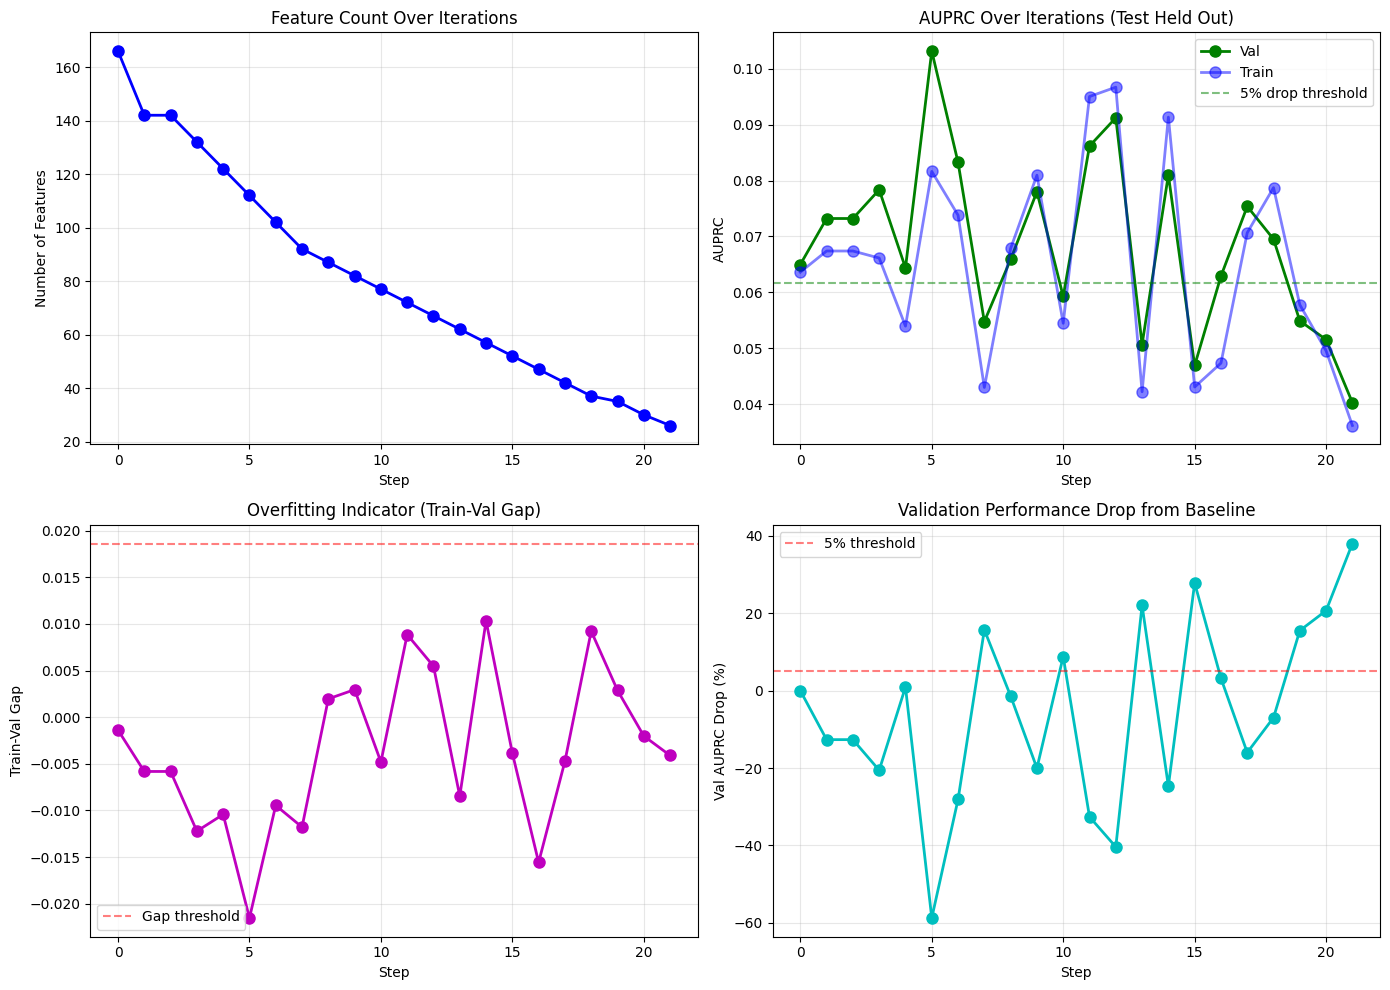

✓ Saved: feature_selection_outputs/iteration_progress.png


In [0]:
# Load tracking data
tracking_path = os.path.join(OUTPUT_DIR, "iteration_tracking.csv")
if os.path.exists(tracking_path):
    tracking_df = pd.read_csv(tracking_path)

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # Feature count over iterations
    axes[0, 0].plot(range(len(tracking_df)), tracking_df['n_features'], 'bo-', linewidth=2, markersize=8)
    axes[0, 0].set_xlabel('Step')
    axes[0, 0].set_ylabel('Number of Features')
    axes[0, 0].set_title('Feature Count Over Iterations')
    axes[0, 0].grid(alpha=0.3)

    # Validation AUPRC (test held out until final evaluation)
    axes[0, 1].plot(range(len(tracking_df)), tracking_df['val_auprc'], 'go-', linewidth=2, markersize=8, label='Val')
    axes[0, 1].plot(range(len(tracking_df)), tracking_df['train_auprc'], 'bo-', linewidth=2, markersize=8, label='Train', alpha=0.5)
    axes[0, 1].axhline(y=baseline_metrics['val']['auprc'] * (1 - MAX_VAL_AUPRC_DROP), color='g', linestyle='--', alpha=0.5, label='5% drop threshold')
    axes[0, 1].set_xlabel('Step')
    axes[0, 1].set_ylabel('AUPRC')
    axes[0, 1].set_title('AUPRC Over Iterations (Test Held Out)')
    axes[0, 1].legend()
    axes[0, 1].grid(alpha=0.3)

    # Train-Val Gap
    axes[1, 0].plot(range(len(tracking_df)), tracking_df['train_val_gap'], 'mo-', linewidth=2, markersize=8)
    axes[1, 0].axhline(y=baseline_metrics['train_val_gap'] + MAX_GAP_INCREASE, color='r', linestyle='--', alpha=0.5, label='Gap threshold')
    axes[1, 0].set_xlabel('Step')
    axes[1, 0].set_ylabel('Train-Val Gap')
    axes[1, 0].set_title('Overfitting Indicator (Train-Val Gap)')
    axes[1, 0].legend()
    axes[1, 0].grid(alpha=0.3)

    # Val drop from baseline
    axes[1, 1].plot(range(len(tracking_df)), tracking_df['val_drop_from_baseline'] * 100, 'co-', linewidth=2, markersize=8)
    axes[1, 1].axhline(y=MAX_VAL_AUPRC_DROP * 100, color='r', linestyle='--', alpha=0.5, label='5% threshold')
    axes[1, 1].set_xlabel('Step')
    axes[1, 1].set_ylabel('Val AUPRC Drop (%)')
    axes[1, 1].set_title('Validation Performance Drop from Baseline')
    axes[1, 1].legend()
    axes[1, 1].grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'iteration_progress.png'), dpi=150, bbox_inches='tight')
    plt.show()

    print(f"✓ Saved: {OUTPUT_DIR}/iteration_progress.png")


## Final Summary

In [0]:
total_elapsed = time.time() - PIPELINE_START_TIME
hours, remainder = divmod(total_elapsed, 3600)
minutes, seconds = divmod(remainder, 60)

print("="*70)
print("FEATURE SELECTION COMPLETE")
print("="*70)
print(f"""
Summary:
  - Initial features: {len(feature_cols)}
  - After Phase 1 (clustering): {len(phase1_features)}
  - Final features: {len(final_features)}
  - Reduction: {(len(feature_cols) - len(final_features))/len(feature_cols)*100:.1f}%

Performance:
  - Baseline Val AUPRC: {baseline_metrics['val']['auprc']:.4f}
  - Final Val AUPRC: {final_metrics['val']['auprc']:.4f}
  - Final Test AUPRC: {final_metrics['test']['auprc']:.4f}

Stop Reason: {stop_reason}

Total Pipeline Time: {int(hours)}h {int(minutes)}m {int(seconds)}s

Outputs saved to: {OUTPUT_DIR}/
  - final_features.txt
  - final_features.py
  - final_model.pkl
  - feature_selection_summary.json
  - iteration_tracking.csv
  - iteration_progress.png
  - threshold_analysis.png

Checkpoints saved to: {CHECKPOINT_DIR}/
  (Can be used to resume if notebook is interrupted)
""")
print("="*70)

FEATURE SELECTION COMPLETE

Summary:
  - Initial features: 166
  - After Phase 1 (clustering): 142
  - Final features: 26
  - Reduction: 84.3%

Performance:
  - Baseline Val AUPRC: 0.0650
  - Final Val AUPRC: 0.0403
  - Final Test AUPRC: 0.0353

Stop Reason: Would go below 25 features

Total Pipeline Time: 6h 34m 37s

Outputs saved to: feature_selection_outputs/
  - final_features.txt
  - final_features.py
  - final_model.pkl
  - feature_selection_summary.json
  - iteration_tracking.csv
  - iteration_progress.png
  - threshold_analysis.png

Checkpoints saved to: checkpoints/
  (Can be used to resume if notebook is interrupted)



---
# Cross-Validation Stability Analysis
---
 
This section runs a simplified feature selection on the remaining CV folds to assess
stability. Features that are consistently selected across folds are more robust.

In [0]:
print_stage("CV STABILITY ANALYSIS (PHASE 3)")
print_progress(f"Running feature selection on {N_CV_FOLDS - 1} additional folds...")
print_progress(f"Stability threshold: features must appear in ≥{CV_FEATURE_THRESHOLD*100:.0f}% of folds")
print_progress("This validates that feature selection is robust across different train/val splits")

# Track features selected in each fold
# Fold 0 is the main pipeline result
fold_selected_features = {0: set(final_features)}

# Test set indices (fixed across folds)
test_mask = df_pandas['SPLIT'] == 'test'
X_test = df_pandas.loc[test_mask].copy()
y_test = df_pandas.loc[test_mask, 'FUTURE_CRC_EVENT'].copy()

# Run on remaining folds (1 and 2)
for fold_idx in range(1, N_CV_FOLDS):
    fold_start_time = time.time()
    print_progress(f"")
    print_progress(f"{'='*50}")
    print_progress(f"CV FOLD {fold_idx + 1} / {N_CV_FOLDS}")
    print_progress(f"{'='*50}")

    # Get train/val split for this fold (convert lists to sets for efficient lookup)
    # Use string key because JSON converts int keys to strings
    fold_train_patients = set(cv_fold_assignments[str(fold_idx)]['train_patients'])
    fold_val_patients = set(cv_fold_assignments[str(fold_idx)]['val_patients'])

    # Create masks
    trainval_mask = df_pandas['SPLIT'].isin(['train', 'val'])
    fold_train_mask = trainval_mask & df_pandas['PAT_ID'].isin(fold_train_patients)
    fold_val_mask = trainval_mask & df_pandas['PAT_ID'].isin(fold_val_patients)

    X_fold_train = df_pandas.loc[fold_train_mask].copy()
    y_fold_train = df_pandas.loc[fold_train_mask, 'FUTURE_CRC_EVENT'].copy()
    X_fold_val = df_pandas.loc[fold_val_mask].copy()
    y_fold_val = df_pandas.loc[fold_val_mask, 'FUTURE_CRC_EVENT'].copy()

    print_progress(f"Train: {len(y_fold_train):,} obs, {int(y_fold_train.sum()):,} events")
    print_progress(f"Val: {len(y_fold_val):,} obs, {int(y_fold_val.sum()):,} events")

    # Calculate scale_pos_weight for this fold
    n_pos_fold = (y_fold_train == 1).sum()
    if n_pos_fold == 0:
        raise ValueError(f"No positive cases in fold {fold_idx} training data. Check SGKF stratification.")
    fold_scale_pos_weight = (y_fold_train == 0).sum() / n_pos_fold

    # Train baseline model on this fold (using clustering features from main pipeline)
    print_progress(f"Training model on {len(phase1_features)} cluster representatives...")
    fold_model = train_xgboost_model(
        X_fold_train, y_fold_train, X_fold_val, y_fold_val,
        phase1_features, fold_scale_pos_weight
    )

    # Compute SHAP on this fold's validation set
    print_progress("Computing SHAP values for this fold...")
    fold_importance_df = compute_shap_values(fold_model, X_fold_val, y_fold_val, phase1_features)

    # Identify removal candidates (same logic as main pipeline)
    zero_threshold = 0.0002
    ratio_threshold = 0.2
    bottom_pct = 0.15

    zero_importance = set(fold_importance_df[fold_importance_df['SHAP_Combined'] < zero_threshold]['Feature'])
    neg_biased = set(fold_importance_df[fold_importance_df['SHAP_Ratio'] < ratio_threshold]['Feature'])
    importance_cutoff = fold_importance_df['SHAP_Combined'].quantile(bottom_pct)
    bottom_features = set(fold_importance_df[fold_importance_df['SHAP_Combined'] < importance_cutoff]['Feature'])

    # Features meeting 2+ criteria
    candidates = (
        (zero_importance & neg_biased) |
        (zero_importance & bottom_features) |
        (neg_biased & bottom_features)
    )

    # Never remove protected features
    median_ratio = fold_importance_df['SHAP_Ratio'].median()
    protected = set(fold_importance_df[fold_importance_df['SHAP_Ratio'] >= median_ratio]['Feature'])
    clinical_protected = set(f for f in CLINICAL_MUST_KEEP_FEATURES if f in phase1_features)
    candidates = candidates - protected - clinical_protected

    # Remove candidates from phase1_features to get this fold's selection
    fold_features = [f for f in phase1_features if f not in candidates]

    print_progress(f"Features selected: {len(fold_features)}")
    fold_selected_features[fold_idx] = set(fold_features)

    # Quick validation
    fold_val_metrics = evaluate_model(fold_model, X_fold_val, y_fold_val, phase1_features, f"Fold {fold_idx + 1} Val")

    fold_elapsed = time.time() - fold_start_time
    print_progress(f"Fold {fold_idx + 1} complete in {fold_elapsed:.1f}s")

# Compute stability statistics
print("\n" + "="*70)
print("STABILITY ANALYSIS RESULTS")
print("="*70)

# Count how many folds each feature appears in
feature_fold_counts = {}
all_features = set()
for fold_idx, features in fold_selected_features.items():
    all_features.update(features)

for feat in all_features:
    count = sum(1 for fold_features in fold_selected_features.values() if feat in fold_features)
    feature_fold_counts[feat] = count

# Categorize by stability
stable_features = [f for f, count in feature_fold_counts.items() if count >= N_CV_FOLDS * CV_FEATURE_THRESHOLD]
unstable_features = [f for f, count in feature_fold_counts.items() if count < N_CV_FOLDS * CV_FEATURE_THRESHOLD]

print(f"\nFeature stability summary:")
print(f"  Total unique features selected across folds: {len(all_features)}")
print(f"  Stable features (≥{int(N_CV_FOLDS * CV_FEATURE_THRESHOLD)}/{N_CV_FOLDS} folds): {len(stable_features)}")
print(f"  Unstable features (<{int(N_CV_FOLDS * CV_FEATURE_THRESHOLD)}/{N_CV_FOLDS} folds): {len(unstable_features)}")

# Show unstable features
if unstable_features:
    print(f"\n  Unstable features (may be overfitting artifacts):")
    for feat in sorted(unstable_features)[:20]:
        count = feature_fold_counts[feat]
        in_final = "✓" if feat in final_features else " "
        print(f"    [{in_final}] {feat}: {count}/{N_CV_FOLDS} folds")
    if len(unstable_features) > 20:
        print(f"    ... and {len(unstable_features) - 20} more")

# Check overlap with final features from main pipeline
final_stable = [f for f in final_features if f in stable_features]
final_unstable = [f for f in final_features if f in unstable_features]

print(f"\n  Final features from main pipeline: {len(final_features)}")
print(f"    - Stable: {len(final_stable)} ({len(final_stable)/len(final_features)*100:.1f}%)")
print(f"    - Unstable: {len(final_unstable)} ({len(final_unstable)/len(final_features)*100:.1f}%)")

# Save stability report
stability_report = {
    'n_folds': N_CV_FOLDS,
    'threshold': CV_FEATURE_THRESHOLD,
    'stable_features': sorted(stable_features),
    'unstable_features': sorted(unstable_features),
    'feature_fold_counts': feature_fold_counts,
    'final_stable': sorted(final_stable),
    'final_unstable': sorted(final_unstable)
}

stability_path = os.path.join(OUTPUT_DIR, "cv_stability_report.json")
with open(stability_path, 'w') as f:
    json.dump(stability_report, f, indent=2)
print(f"\n✓ Saved stability report: {stability_path}")

# Optionally update final features to only include stable ones
print(f"\n{'='*70}")
print("RECOMMENDATION")
print("="*70)
if len(final_unstable) > 0:
    print(f"Consider reviewing the {len(final_unstable)} unstable features in the final set.")
    print("These may be overfitting to the specific train/val split.")
    print(f"For a more robust model, use only the {len(final_stable)} stable features.")
else:
    print("All final features are stable across CV folds. Feature selection is robust.")

# COMMAND ----------


[01:28:04] CV STABILITY ANALYSIS (PHASE 3)
  [01:28:04] Running feature selection on 2 additional folds...
  [01:28:04] Stability threshold: features must appear in ≥67% of folds
  [01:28:04] This validates that feature selection is robust across different train/val splits
  [01:28:04] 
  [01:28:04] ==================================================
  [01:28:04] CV FOLD 2 / 3
  [01:28:04] ==================================================
  [01:28:05] Train: 486,965 obs, 1,827 events
  [01:28:05] Val: 242,733 obs, 812 events
  [01:28:05] Training model on 142 cluster representatives...
  [01:28:05] Training XGBoost with 142 features...
  [01:28:05] Train: 486,965 obs, 1,827 events | Val: 242,733 obs, 812 events


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run unique-elk-644 at: https://adb-2845170968234247.7.azuredatabricks.net/ml/experiments/7b6f512c605b4f1a9990c2f59e14c59f/runs/b29924e7022a43b59f3d23632614bbb9
🧪 View experiment at: https://adb-2845170968234247.7.azuredatabricks.net/ml/experiments/7b6f512c605b4f1a9990c2f59e14c59f
  [01:37:07] Model trained in 542.5s (best iteration: 47)
  [01:37:07] Computing SHAP values for this fold...
  [01:37:07] Starting SHAP computation...
  [01:37:07] Positive cases: 812 | Negative cases: 241,921
  [01:37:07] Creating TreeExplainer...
  [01:37:07] Computing SHAP for 812 positive cases (this may take a while)...


[01:37:07] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


  [01:37:08] Positive cases complete in 0.9s (939 cases/sec)
  [01:37:08] Sampling 50,000 from 241,921 negative cases for SHAP...
  [01:37:08] Computing SHAP for 50,000 negative cases...
  [01:37:39] Negative cases complete in 31.2s (1601 cases/sec)
  [01:37:39] Calculating importance metrics...
  [01:37:39] SHAP computation complete in 32.3s total
  [01:37:39] Features selected: 142
  Fold 2 Val: AUPRC=0.0916 (27.4x lift), AUROC=0.7582
  [01:40:29] Fold 2 complete in 744.9s
  [01:40:29] 
  [01:40:29] ==================================================
  [01:40:29] CV FOLD 3 / 3
  [01:40:29] ==================================================
  [01:40:29] Train: 485,546 obs, 1,690 events
  [01:40:29] Val: 244,152 obs, 949 events
  [01:40:29] Training model on 142 cluster representatives...
  [01:40:29] Training XGBoost with 142 features...
  [01:40:29] Train: 485,546 obs, 1,690 events | Val: 244,152 obs, 949 events


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run loud-vole-363 at: https://adb-2845170968234247.7.azuredatabricks.net/ml/experiments/7b6f512c605b4f1a9990c2f59e14c59f/runs/1e04b129baa2478da301d809bf2d78c5
🧪 View experiment at: https://adb-2845170968234247.7.azuredatabricks.net/ml/experiments/7b6f512c605b4f1a9990c2f59e14c59f
  [01:49:31] Model trained in 541.8s (best iteration: 47)
  [01:49:31] Computing SHAP values for this fold...
  [01:49:31] Starting SHAP computation...
  [01:49:31] Positive cases: 949 | Negative cases: 243,203
  [01:49:31] Creating TreeExplainer...
  [01:49:31] Computing SHAP for 949 positive cases (this may take a while)...


[01:49:31] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


  [01:49:32] Positive cases complete in 0.9s (1091 cases/sec)
  [01:49:32] Sampling 50,000 from 243,203 negative cases for SHAP...
  [01:49:32] Computing SHAP for 50,000 negative cases...
  [01:50:03] Negative cases complete in 30.8s (1625 cases/sec)
  [01:50:03] Calculating importance metrics...
  [01:50:03] SHAP computation complete in 31.9s total
  [01:50:03] Features selected: 142
  Fold 3 Val: AUPRC=0.0512 (13.2x lift), AUROC=0.7696
  [01:52:54] Fold 3 complete in 745.6s

STABILITY ANALYSIS RESULTS

Feature stability summary:
  Total unique features selected across folds: 142
  Stable features (≥2/3 folds): 26
  Unstable features (<2/3 folds): 116

  Unstable features (may be overfitting artifacts):
    [ ] HAS_PCP_AT_END: 2/3 folds
    [ ] IS_FEMALE: 2/3 folds
    [ ] IS_MARRIED_PARTNER: 2/3 folds
    [ ] RACE_ASIAN: 2/3 folds
    [ ] RACE_BLACK_OR_AFRICAN_AMERICAN: 2/3 folds
    [ ] RACE_HISPANIC: 2/3 folds
    [ ] had_fobt_in_lookback: 2/3 folds
    [ ] icd_ANEMIA_FLAG_12MO: 2/

## Utility: Clear Checkpoints (Run Manually if Needed)

In [0]:
# Uncomment and run this cell to clear all checkpoints and start fresh
clear_checkpoints()
print("Checkpoints cleared. Re-run notebook to start fresh.")

✓ All checkpoints cleared
Checkpoints cleared. Re-run notebook to start fresh.


In [0]:
import pandas as pd# Set the option to display all rows

pd.set_option('display.max_rows', None)

df_check_spark = spark.sql('select * from dev.clncl_ds.herald_eda_train_wide')
df_check = df_check_spark.toPandas()
df_check.isnull().sum()/df_check.shape[0]

The conversion of DecimalType columns is inefficient and may take a long time. Column names: [AGE] If those columns are not necessary, you may consider dropping them or converting to primitive types before the conversion.


PAT_ID                                      0.000000
END_DTTM                                    0.000000
AGE                                         0.000000
IS_FEMALE                                   0.000000
IS_MARRIED_PARTNER                          0.000000
OBS_MONTHS_PRIOR                            0.000000
data_quality_flag                           0.000000
RACE_CAUCASIAN                              0.000000
RACE_BLACK_OR_AFRICAN_AMERICAN              0.000000
RACE_HISPANIC                               0.000000
RACE_ASIAN                                  0.000000
RACE_OTHER                                  0.000000
HAS_FULL_24M_HISTORY                        0.000000
age_group                                   0.000000
HAS_PCP_AT_END                              0.000000
FUTURE_CRC_EVENT                            0.000000
ICD10_CODE                                  0.996398
ICD10_GROUP                                 0.996398
LABEL_USABLE                                0.

In [0]:
pd.set_option('display.max_rows', None)

df_check_spark = spark.sql('select * from dev.clncl_ds.herald_train')
df_check = df_check_spark.toPandas()
df_check.isnull().sum()/df_check.shape[0]

The conversion of DecimalType columns is inefficient and may take a long time. Column names: [visit_acute_care_reliance, visit_primary_care_continuity_ratio] If those columns are not necessary, you may consider dropping them or converting to primitive types before the conversion.


PAT_ID                                 0.000000
END_DTTM                               0.000000
FUTURE_CRC_EVENT                       0.000000
ICD10_GROUP                            0.996396
AGE_GROUP                              0.000000
IS_FEMALE                              0.000000
IS_MARRIED_PARTNER                     0.000000
RACE_ASIAN                             0.000000
RACE_CAUCASIAN                         0.000000
HAS_PCP_AT_END                         0.000000
months_since_cohort_entry              0.000000
vit_BMI                                0.291123
vit_BMI_CHANGE_6M                      0.751290
vit_PULSE                              0.353730
vit_PULSE_PRESSURE                     0.296789
vit_RECENCY_WEIGHT                     0.262945
vit_CACHEXIA_RISK_SCORE                0.000000
vit_WEIGHT_TRAJECTORY_SLOPE            0.543476
vit_MAX_WEIGHT_LOSS_PCT_60D            0.709001
vit_SBP_VARIABILITY_6M                 0.800601
icd_MALIGNANCY_FLAG_EVER               0